# Readme:

Reproducing results of this github: https://github.com/oscarknagg/few-shot
with the matching network from this paper: https://arxiv.org/pdf/1606.04080.pdf

# Mount Drive:

In [1]:
#Import drive
from google.colab import drive
#Mount Google Drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir('drive/My Drive/Work/Thesis_Julien_Dejasmin/Work/code/Binary_activations_V2/MNIST_binary_V2')

In [0]:
!ls

config.py   distributions  models	requirements.txt  utils
data	    experiments    __pycache__	results		  visualize
DataLoader  logs	   README.md	trained_models


# Import:

In [0]:
from torch.optim import Adam
from torch import load
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import cv2

from DataLoader.dataset import OmniglotDataset
from utils.core import prepare_nshot_task, EvaluateFewShot
from utils.models import BinaryMatchingNetwork, NoBinaryMatchingNetwork
from utils.training import fit
from utils.callback import *
from config import PATH
from utils.training import gpu_config
from utils.matching import matching_net_episode
from DataLoader.dataLoaders import get_omniglot_dataloader_v2

from visualize.viz import visTensor, get_activation

# Parameters:

In [0]:
##############
# Parameters #
##############
distance = 'l2'
n_train = 1
k_train = 5
q_train = 15
n_test = 1
k_test = 5
q_test = 1

evaluation_episodes = 1000
episodes_per_epoch = 10

n_epochs = 10
dataset_class = OmniglotDataset
num_input_channels = 1

# Dataset:

## Prepare Omniglot data:

In [0]:
# prepare dataset:
# from DataLoader.prepare_omniglot import prepare_omniglot
# prepare_omniglot()

## DataLoaders:

In [0]:
###########
# Dataset #
###########
background_taskloader, evaluation_taskloader = get_omniglot_dataloader_v2(episodes_per_epoch, n_train, k_train,
                                                                          q_train, n_test, k_test, q_test,
                                                                          dataset_class)

Indexing background...


100%|██████████| 77120/77120 [00:02<00:00, 27471.03it/s]


Indexing evaluation...


100%|██████████| 52720/52720 [00:01<00:00, 26524.86it/s]


Number of training examples: 10
Number of testing examples: 10


# No binary Omniglot Expes:

## Parameters:

In [0]:
binary_model = False
slope_annealing = False

param_str = f'_n={n_train}_k={k_train}_q={q_train}_' \
            f'nv={n_test}_kv={k_test}_qv={q_test}_'\
            f'dist={distance}'

## Model:

In [0]:
#########
# Model #
#########
model = NoBinaryMatchingNetwork(n_train, k_train, q_train, num_input_channels)
model, use_gpu = gpu_config(model)
model.double()

use 1 gpu who named: Tesla P100-PCIE-16GB


NoBinaryMatchingNetwork(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(64, 64, kernel_

## Training:

In [0]:
optimiser = Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.NLLLoss().cuda()

callbacks = [
    EvaluateFewShot(
        binary_model=binary_model,
        slope=1.0,
        use_gpu=use_gpu,
        eval_fn=matching_net_episode,
        num_tasks=evaluation_episodes,
        n_shot=n_test,
        k_way=k_test,
        q_queries=q_test,
        taskloader=evaluation_taskloader,
        prepare_batch=prepare_nshot_task(use_gpu, n_test, k_test, q_test),
        distance=distance
    ),
    ModelCheckpoint(
        filepath=PATH + f'/trained_models/Omniglot/matching_nets/NoBinary/{param_str}.pth',
        monitor=f'val_{n_test}-shot_{k_test}-way_acc',
        # monitor=f'val_loss',
    ),
    ReduceLROnPlateau(patience=20, factor=0.5, monitor=f'val_{n_test}-shot_{k_test}-way_acc'),
    CSVLogger(PATH + f'/results/Omniglot_results/logs/matching_nets/NoBinary/{param_str}.csv'),
]

In [0]:
binary_model = False
slope_annealing = False

fit(
    binary_model,
    slope_annealing,
    use_gpu,
    model,
    optimiser,
    loss_fn,
    epochs=n_epochs,
    dataloader=background_taskloader,
    prepare_batch=prepare_nshot_task(use_gpu, n_train, k_train, q_train),
    callbacks=callbacks,
    metrics=['categorical_accuracy'],
    fit_function=matching_net_episode,
    fit_function_kwargs={'n_shot': n_train, 'k_way': k_train, 'q_queries': q_train, 'distance': distance, 'train': True}
)


Epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]

Begin training...



Epoch 1: 100%|██████████| 10/10 [01:31<00:00,  9.16s/it, loss=2.1, categorical_accuracy=0.703]

Epoch 2: 100%|██████████| 10/10 [01:25<00:00,  8.53s/it, loss=1.16, categorical_accuracy=0.792]

Epoch 3: 100%|██████████| 10/10 [01:23<00:00,  8.34s/it, loss=1.09, categorical_accuracy=0.756]

Epoch 4: 100%|██████████| 10/10 [01:22<00:00,  8.23s/it, loss=0.849, categorical_accuracy=0.752]

Epoch 5: 100%|██████████| 10/10 [01:24<00:00,  8.43s/it, loss=0.701, categorical_accuracy=0.768]

Epoch 6: 100%|██████████| 10/10 [01:22<00:00,  8.30s/it, loss=0.57, categorical_accuracy=0.801]

Epoch 7: 100%|██████████| 10/10 [01:16<00:00,  7.68s/it, loss=0.561, categorical_accuracy=0.813]

Epoch 8: 100%|██████████| 10/10 [01:24<00:00,  8.45s/it, loss=0.555, categorical_accuracy=0.797]

Epoch 9: 100%|██████████| 10/10 [01:25<00:00,  8.57s/it, loss=0.452, categorical_accuracy=0.821]

Epoch 10: 100%|██████████| 10/10 [01:20<00:00,  8.01s/it, loss=0.453, categorical_accuracy=0.857]

Finished.


### Plot acc/loss train:

In [0]:
def plot_loss_acc(loss_values_train, acc_values_train, loss_values_valid, acc_values_valid, path_save_fig, name_model):
    # summarize history for accuracy
    plt.plot(np.array(acc_values_train))
    plt.plot(np.array(acc_values_valid))
    plt.title('model accuracy all_binary_model')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.xlim(0, 10)
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig(path_save_fig + 'acc_model_' + name_model + '.png')
    plt.show()
    # summarize history for loss
    plt.plot(np.array(loss_values_train))
    plt.plot(np.array(loss_values_valid))
    plt.title('model loss all_binary_model')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.xlim(0, 10)
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(path_save_fig + 'loss_model_' + name_model + '.png')
    plt.show()

In [0]:
import csv
train_acc = []
train_loss = []
val_acc = []
val_loss = []
path_save_fig = 'results/Omniglot_results/plot_acc_loss/No_Binary/'
with open(f'results/Omniglot_results/logs/matching_nets/NoBinary/{param_str}.csv', newline='') as csvfile:
     reader = csv.DictReader(csvfile)
     for row in reader:
       train_acc.append(float(row['categorical_accuracy']))
       train_loss.append(float(row['loss']))
       val_acc.append(float(row['val_1-shot_5-way_acc']))
       val_loss.append(float(row['val_loss']))

print(train_acc, train_loss, val_acc, val_loss)


[0.7026666666666667, 0.7920000000000001, 0.7560000000000001, 0.752, 0.768, 0.8013333333333333, 0.8133333333333332, 0.7973333333333333, 0.8213333333333332, 0.8573333333333333] [2.104287913513441, 1.1609025717093833, 1.0870123655266073, 0.8491624999140818, 0.7014528157320702, 0.5696974590719571, 0.5612485399407076, 0.5550898496917309, 0.451805199095923, 0.4525841653977821] [0.44, 0.62, 0.74, 0.82, 0.76, 0.84, 0.86, 0.76, 0.8, 0.84] [1.5924072702723575, 1.202949864179473, 0.769391296713978, 0.5381571792938985, 0.8621403412271347, 1.0207692265302541, 0.4157242334214697, 0.7614003585715885, 0.6756177308612625, 0.43197904722653646]


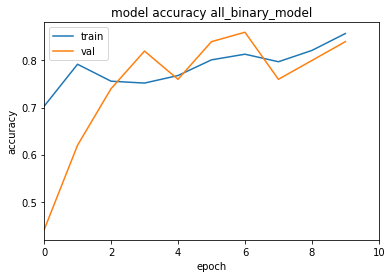

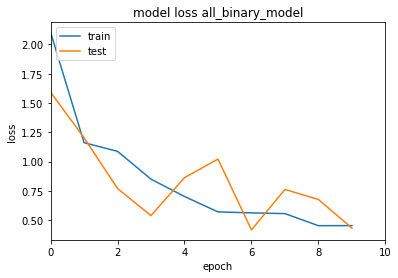

In [0]:
plot_loss_acc(train_loss, train_acc, val_loss, val_acc, path_save_fig, 'MN_no_binary')

## Test:

In [0]:
# load model pretrained on Omniglot:
model = NoBinaryMatchingNetwork(n_train, k_train, q_train, num_input_channels)
model, use_gpu = gpu_config(model)
model.double()
model.load_state_dict(load(f'trained_models/Omniglot/matching_nets/NoBinary/{param_str}.pth'))

use 1 gpu who named: Tesla P100-PCIE-16GB


<All keys matched successfully>

In [0]:
# test model on evaluation dataset:
optimiser = Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.NLLLoss().cuda()

callbacks_test = [
    EvaluateFewShot(
        binary_model=binary_model,
        slope=1.0,
        use_gpu=use_gpu,
        eval_fn=matching_net_episode,
        num_tasks=evaluation_episodes,
        n_shot=n_test,
        k_way=k_test,
        q_queries=q_test,
        taskloader=evaluation_taskloader,
        prepare_batch=prepare_nshot_task(use_gpu, n_test, k_test, q_test),
        distance=distance
    ),
]

fit(
    binary_model,
    slope_annealing,
    use_gpu,
    model,
    optimiser,
    loss_fn,
    epochs=5,
    dataloader=evaluation_taskloader,
    prepare_batch=prepare_nshot_task(use_gpu, n_test, k_test, q_test),
    callbacks=callbacks_test,
    metrics=['categorical_accuracy'],
    fit_function=matching_net_episode,
    fit_function_kwargs={'n_shot': n_test, 'k_way': k_test, 'q_queries': q_test, 'distance': distance, 'train': False}
)



Epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]

Begin training...




Epoch 1:  10%|█         | 1/10 [00:04<00:43,  4.82s/it]

Epoch 1:  10%|█         | 1/10 [00:04<00:43,  4.82s/it, loss=3.85, categorical_accuracy=0.8]

Epoch 1:  20%|██        | 2/10 [00:04<00:38,  4.82s/it, loss=0.685, categorical_accuracy=0.6]

Epoch 1:  30%|███       | 3/10 [00:05<00:23,  3.42s/it, loss=0.685, categorical_accuracy=0.6]

Epoch 1:  30%|███       | 3/10 [00:05<00:23,  3.42s/it, loss=0.291, categorical_accuracy=0.8]

Epoch 1:  40%|████      | 4/10 [00:05<00:20,  3.42s/it, loss=0.0276, categorical_accuracy=1] 

Epoch 1:  50%|█████     | 5/10 [00:09<00:15,  3.01s/it, loss=0.0276, categorical_accuracy=1]

Epoch 1:  50%|█████     | 5/10 [00:09<00:15,  3.01s/it, loss=0.0758, categorical_accuracy=1]

Epoch 1:  60%|██████    | 6/10 [00:09<00:12,  3.01s/it, loss=0.011, categorical_accuracy=1] 

Epoch 1:  70%|███████   | 7/10 [00:09<00:09,  3.01s/it, loss=2.54, categorical_accuracy=0.6]

Epoch 1:  80%|████████  | 8/10 [00:11<00:04,  2.33s/it, loss=2.54, categorical_accuracy=0.6

Finished.


# Binary Omniglot first conv layer Expes:

## Parameters:

In [0]:
##############
# Parameters #
##############
first_binary_conv_layer = True
second_binary_conv_layer = False
third_binary_conv_layer = False
fourth_binary_conv_layer = False
slope_annealing = True
binary_model = True

param_str = f'frist_conv={first_binary_conv_layer}_second_conv={second_binary_conv_layer}_'\
            f'third_conv={third_binary_conv_layer}_fourth_conv={fourth_binary_conv_layer}_'\
            f'_n={n_train}_k={k_train}_q={q_train}_' \
            f'nv={n_test}_kv={k_test}_qv={q_test}_'\
            f'dist={distance}'

## Model

In [0]:
#########
# Model #
#########
model = BinaryMatchingNetwork(first_binary_conv_layer, second_binary_conv_layer,
                              third_binary_conv_layer, fourth_binary_conv_layer,
                              n_train, k_train, q_train, num_input_channels)
model, use_gpu = gpu_config(model)
model.double()

use 1 gpu who named: Tesla P4


BinaryMatchingNetwork(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (act_layer1): DeterministicBinaryActivation(
    (act): Hardsigmoid(
      (act): Hardtanh(min_val=-1.0, max_val=1.0)
    )
  )
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (act_layer2): ReLU()
  (layer3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

## Training:

In [0]:
optimiser = Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.NLLLoss().cuda()

callbacks = [
    EvaluateFewShot(
        binary_model=binary_model,
        slope=1.0,
        use_gpu=use_gpu,
        eval_fn=matching_net_episode,
        num_tasks=evaluation_episodes,
        n_shot=n_test,
        k_way=k_test,
        q_queries=q_test,
        taskloader=evaluation_taskloader,
        prepare_batch=prepare_nshot_task(use_gpu, n_test, k_test, q_test),
        distance=distance
    ),
    ModelCheckpoint(
        filepath=PATH + f'/trained_models/Omniglot/matching_nets/Binary/{param_str}.pth',
        monitor=f'val_{n_test}-shot_{k_test}-way_acc',
        # monitor=f'val_loss',
    ),
    ReduceLROnPlateau(patience=20, factor=0.5, monitor=f'val_{n_test}-shot_{k_test}-way_acc'),
    CSVLogger(PATH + f'/results/Omniglot_results/logs/matching_nets/Binary/{param_str}.csv'),
]

In [0]:
fit(
    binary_model,
    slope_annealing,
    use_gpu,
    model,
    optimiser,
    loss_fn,
    epochs=n_epochs,
    dataloader=background_taskloader,
    prepare_batch=prepare_nshot_task(use_gpu, n_train, k_train, q_train),
    callbacks=callbacks,
    metrics=['categorical_accuracy'],
    fit_function=matching_net_episode,
    fit_function_kwargs={'n_shot': n_train, 'k_way': k_train, 'q_queries': q_train, 'distance': distance, 'train': True}
)


Epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]

Begin training...



Epoch 1: 100%|██████████| 10/10 [01:19<00:00,  7.93s/it, loss=2.68, categorical_accuracy=0.631]

Epoch 2: 100%|██████████| 10/10 [01:20<00:00,  8.04s/it, loss=1.75, categorical_accuracy=0.7]

Epoch 3: 100%|██████████| 10/10 [01:19<00:00,  7.92s/it, loss=0.994, categorical_accuracy=0.749]

Epoch 4: 100%|██████████| 10/10 [01:12<00:00,  7.25s/it, loss=0.653, categorical_accuracy=0.761]

Epoch 5: 100%|██████████| 10/10 [01:16<00:00,  7.65s/it, loss=0.684, categorical_accuracy=0.767]

Epoch 6: 100%|██████████| 10/10 [01:13<00:00,  7.32s/it, loss=0.723, categorical_accuracy=0.772]

Epoch 7: 100%|██████████| 10/10 [01:03<00:00,  6.36s/it, loss=0.428, categorical_accuracy=0.841]

Epoch 8: 100%|██████████| 10/10 [01:15<00:00,  7.55s/it, loss=0.607, categorical_accuracy=0.789]

Epoch 9: 100%|██████████| 10/10 [01:06<00:00,  6.68s/it, loss=0.579, categorical_accuracy=0.828]

Epoch 10: 100%|██████████| 10/10 [01:12<00:00,  7.24s/it, loss=0.485, categorical_accuracy=0.832]

Finished.


## Plot acc/loss training:

In [0]:
import csv
train_acc = []
train_loss = []
val_acc = []
val_loss = []
path_save_fig = 'results/Omniglot_results/plot_acc_loss/Binary/'
with open(f'results/Omniglot_results/logs/matching_nets/Binary/{param_str}.csv', newline='') as csvfile:
     reader = csv.DictReader(csvfile)
     for row in reader:
       train_acc.append(float(row['categorical_accuracy']))
       train_loss.append(float(row['loss']))
       val_acc.append(float(row['val_1-shot_5-way_acc']))
       val_loss.append(float(row['val_loss']))

print(train_acc, train_loss, val_acc, val_loss)


[0.6306666666666666, 0.7, 0.7493333333333333, 0.7613333333333333, 0.7666666666666668, 0.772, 0.8413333333333334, 0.7893333333333333, 0.8280000000000001, 0.8320000000000001] [2.6833059294313735, 1.751061067421615, 0.9936516668525774, 0.6532110505472358, 0.6837392044866396, 0.7233083011355612, 0.4279834112236965, 0.6071095476599259, 0.579427085704353, 0.4846858838814068] [0.64, 0.68, 0.74, 0.74, 0.66, 0.68, 0.74, 0.76, 0.74, 0.72] [1.2967014883647832, 1.0644108007124573, 0.993062546541736, 0.7978175786961978, 1.1146040155349988, 0.7860705145489391, 0.6398912942325672, 0.6374331564478887, 0.9398085249963509, 0.8183885807634417]


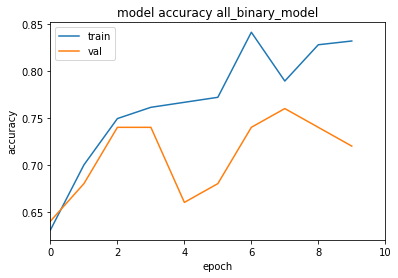

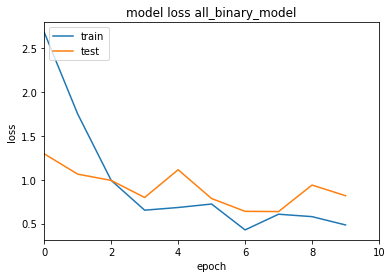

In [0]:
plot_loss_acc(train_loss, train_acc, val_loss, val_acc, path_save_fig, 'MN_binary_first_conv')

## Test:


In [0]:
# load model pretrained on Omniglot:
model = BinaryMatchingNetwork(first_binary_conv_layer, second_binary_conv_layer,
                              third_binary_conv_layer, fourth_binary_conv_layer,
                              n_train, k_train, q_train, num_input_channels)
model, use_gpu = gpu_config(model)
model.double()
model.load_state_dict(load(f'trained_models/Omniglot/matching_nets/Binary/{param_str}.pth'))

use 1 gpu who named: Tesla P100-PCIE-16GB


<All keys matched successfully>

In [0]:
# test model on evaluation dataset:
optimiser = Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.NLLLoss().cuda()

callbacks_test = [
    EvaluateFewShot(
        binary_model=binary_model,
        slope=1.0,
        use_gpu=use_gpu,
        eval_fn=matching_net_episode,
        num_tasks=evaluation_episodes,
        n_shot=n_test,
        k_way=k_test,
        q_queries=q_test,
        taskloader=evaluation_taskloader,
        prepare_batch=prepare_nshot_task(use_gpu, n_test, k_test, q_test),
        distance=distance
    ),
]

fit(
    binary_model,
    slope_annealing,
    use_gpu,
    model,
    optimiser,
    loss_fn,
    epochs=5,
    dataloader=evaluation_taskloader,
    prepare_batch=prepare_nshot_task(use_gpu, n_test, k_test, q_test),
    callbacks=callbacks_test,
    metrics=['categorical_accuracy'],
    fit_function=matching_net_episode,
    fit_function_kwargs={'n_shot': n_test, 'k_way': k_test, 'q_queries': q_test, 'distance': distance, 'train': False}
)




Epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]

Begin training...





Epoch 1:  10%|█         | 1/10 [00:03<00:35,  3.95s/it]


Epoch 1:  10%|█         | 1/10 [00:03<00:35,  3.95s/it, loss=0.998, categorical_accuracy=0.4]


Epoch 1:  20%|██        | 2/10 [00:04<00:23,  2.97s/it, loss=0.998, categorical_accuracy=0.4]


Epoch 1:  20%|██        | 2/10 [00:04<00:23,  2.97s/it, loss=0.282, categorical_accuracy=0.8]


Epoch 1:  30%|███       | 3/10 [00:04<00:20,  2.97s/it, loss=1.37, categorical_accuracy=0.2] 


Epoch 1:  40%|████      | 4/10 [00:05<00:13,  2.18s/it, loss=1.37, categorical_accuracy=0.2]


Epoch 1:  40%|████      | 4/10 [00:05<00:13,  2.18s/it, loss=0.141, categorical_accuracy=1] 


Epoch 1:  50%|█████     | 5/10 [00:07<00:10,  2.13s/it, loss=0.141, categorical_accuracy=1]


Epoch 1:  50%|█████     | 5/10 [00:07<00:10,  2.13s/it, loss=1.9, categorical_accuracy=0.6]


Epoch 1:  60%|██████    | 6/10 [00:08<00:07,  1.79s/it, loss=1.9, categorical_accuracy=0.6]


Epoch 1:  60%|██████    | 6/10 [00:08<00:07,  1.79s/it, loss=0.0605, categorical_ac

Finished.


# Binary MN second conv layer Expes:

## Parameters:

In [0]:
##############
# Parameters #
##############
first_binary_conv_layer = False
second_binary_conv_layer = True
third_binary_conv_layer = False
fourth_binary_conv_layer = False
slope_annealing = True
binary_model = True

param_str = f'frist_conv={first_binary_conv_layer}_second_conv={second_binary_conv_layer}_'\
            f'third_conv={third_binary_conv_layer}_fourth_conv={fourth_binary_conv_layer}_'\
            f'_n={n_train}_k={k_train}_q={q_train}_' \
            f'nv={n_test}_kv={k_test}_qv={q_test}_'\
            f'dist={distance}'

## Model:

In [0]:
#########
# Model #
#########
model = BinaryMatchingNetwork(first_binary_conv_layer, second_binary_conv_layer,
                              third_binary_conv_layer, fourth_binary_conv_layer,
                              n_train, k_train, q_train, num_input_channels)
model, use_gpu = gpu_config(model)
model.double()

use 1 gpu who named: Tesla P4


BinaryMatchingNetwork(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (act_layer1): ReLU()
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (act_layer2): DeterministicBinaryActivation(
    (act): Hardsigmoid(
      (act): Hardtanh(min_val=-1.0, max_val=1.0)
    )
  )
  (layer3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

## Training:

In [0]:
optimiser = Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.NLLLoss().cuda()

callbacks = [
    EvaluateFewShot(
        binary_model=binary_model,
        slope=1.0,
        use_gpu=use_gpu,
        eval_fn=matching_net_episode,
        num_tasks=evaluation_episodes,
        n_shot=n_test,
        k_way=k_test,
        q_queries=q_test,
        taskloader=evaluation_taskloader,
        prepare_batch=prepare_nshot_task(use_gpu, n_test, k_test, q_test),
        distance=distance
    ),
    ModelCheckpoint(
        filepath=PATH + f'/trained_models/Omniglot/matching_nets/Binary/{param_str}.pth',
        monitor=f'val_{n_test}-shot_{k_test}-way_acc',
        # monitor=f'val_loss',
    ),
    ReduceLROnPlateau(patience=20, factor=0.5, monitor=f'val_{n_test}-shot_{k_test}-way_acc'),
    CSVLogger(PATH + f'/results/Omniglot_results/logs/matching_nets/Binary/{param_str}.csv'),
]

In [0]:
fit(
    binary_model,
    slope_annealing,
    use_gpu,
    model,
    optimiser,
    loss_fn,
    epochs=n_epochs,
    dataloader=background_taskloader,
    prepare_batch=prepare_nshot_task(use_gpu, n_train, k_train, q_train),
    callbacks=callbacks,
    metrics=['categorical_accuracy'],
    fit_function=matching_net_episode,
    fit_function_kwargs={'n_shot': n_train, 'k_way': k_train, 'q_queries': q_train, 'distance': distance, 'train': True}
)


Epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]

Begin training...



Epoch 1: 100%|██████████| 10/10 [01:15<00:00,  7.51s/it, loss=2.36, categorical_accuracy=0.603]

Epoch 2: 100%|██████████| 10/10 [01:20<00:00,  8.01s/it, loss=1.34, categorical_accuracy=0.633]

Epoch 3: 100%|██████████| 10/10 [01:06<00:00,  6.62s/it, loss=0.919, categorical_accuracy=0.633]

Epoch 4: 100%|██████████| 10/10 [01:18<00:00,  7.90s/it, loss=0.797, categorical_accuracy=0.723]

Epoch 5: 100%|██████████| 10/10 [01:15<00:00,  7.54s/it, loss=0.742, categorical_accuracy=0.704]

Epoch 6: 100%|██████████| 10/10 [01:20<00:00,  8.08s/it, loss=0.721, categorical_accuracy=0.757]

Epoch 7: 100%|██████████| 10/10 [01:16<00:00,  7.62s/it, loss=0.718, categorical_accuracy=0.749]

Epoch 8: 100%|██████████| 10/10 [01:05<00:00,  6.52s/it, loss=0.729, categorical_accuracy=0.749]

Epoch 9: 100%|██████████| 10/10 [01:07<00:00,  6.71s/it, loss=0.713, categorical_accuracy=0.776]

Epoch 10: 100%|██████████| 10/10 [00:56<00:00,  5.66s/it, loss=0.823, categorical_accuracy=0.765]

Finished.


## Plot acc/loss training:

In [0]:
import csv
train_acc = []
train_loss = []
val_acc = []
val_loss = []
path_save_fig = 'results/Omniglot_results/plot_acc_loss/Binary/'
with open(f'results/Omniglot_results/logs/matching_nets/Binary/{param_str}.csv', newline='') as csvfile:
     reader = csv.DictReader(csvfile)
     for row in reader:
       train_acc.append(float(row['categorical_accuracy']))
       train_loss.append(float(row['loss']))
       val_acc.append(float(row['val_1-shot_5-way_acc']))
       val_loss.append(float(row['val_loss']))

print(train_acc, train_loss, val_acc, val_loss)

[0.6026666666666667, 0.6333333333333334, 0.6333333333333334, 0.7226666666666667, 0.704, 0.7573333333333334, 0.7493333333333333, 0.7493333333333332, 0.776, 0.7653333333333334] [2.363946632395949, 1.3408332098666107, 0.9186041405923124, 0.7973449088426283, 0.7424545056479781, 0.7207536040744734, 0.7179631114172691, 0.7287222118528762, 0.7128085877035824, 0.8230196811118201] [0.64, 0.56, 0.62, 0.68, 0.68, 0.68, 0.74, 0.68, 0.8, 0.8] [1.2135017436913427, 1.0738100592568511, 1.0132149228445968, 0.9980765598259653, 1.0292358324572815, 1.0408070908938662, 0.6454060923979729, 0.8270224666086926, 0.5763863074810608, 0.5920975005955453]


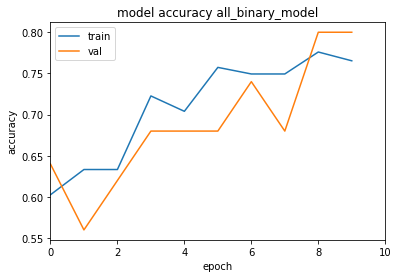

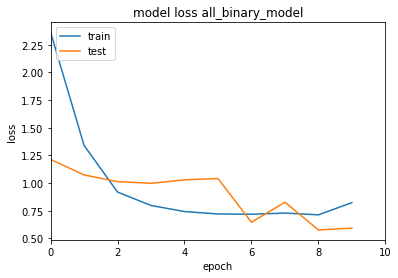

In [0]:
plot_loss_acc(train_loss, train_acc, val_loss, val_acc, path_save_fig, 'MN_binary_second_conv')

## Test:

In [0]:
# load model pretrained on Omniglot:
model = BinaryMatchingNetwork(first_binary_conv_layer, second_binary_conv_layer,
                              third_binary_conv_layer, fourth_binary_conv_layer,
                              n_train, k_train, q_train, num_input_channels)
model, use_gpu = gpu_config(model)
model.double()
model.load_state_dict(load(f'trained_models/Omniglot/matching_nets/Binary/{param_str}.pth'))

use 1 gpu who named: Tesla P100-PCIE-16GB


<All keys matched successfully>

In [0]:
# test model on evaluation dataset:
optimiser = Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.NLLLoss().cuda()

callbacks_test = [
    EvaluateFewShot(
        binary_model=binary_model,
        slope=1.0,
        use_gpu=use_gpu,
        eval_fn=matching_net_episode,
        num_tasks=evaluation_episodes,
        n_shot=n_test,
        k_way=k_test,
        q_queries=q_test,
        taskloader=evaluation_taskloader,
        prepare_batch=prepare_nshot_task(use_gpu, n_test, k_test, q_test),
        distance=distance
    ),
]

fit(
    binary_model,
    slope_annealing,
    use_gpu,
    model,
    optimiser,
    loss_fn,
    epochs=5,
    dataloader=evaluation_taskloader,
    prepare_batch=prepare_nshot_task(use_gpu, n_test, k_test, q_test),
    callbacks=callbacks_test,
    metrics=['categorical_accuracy'],
    fit_function=matching_net_episode,
    fit_function_kwargs={'n_shot': n_test, 'k_way': k_test, 'q_queries': q_test, 'distance': distance, 'train': False}
)




Epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]

Begin training...





Epoch 1:  10%|█         | 1/10 [00:03<00:27,  3.04s/it]


Epoch 1:  10%|█         | 1/10 [00:03<00:27,  3.04s/it, loss=0.272, categorical_accuracy=1]


Epoch 1:  20%|██        | 2/10 [00:03<00:18,  2.37s/it, loss=0.272, categorical_accuracy=1]


Epoch 1:  20%|██        | 2/10 [00:03<00:18,  2.37s/it, loss=0.502, categorical_accuracy=1]


Epoch 1:  30%|███       | 3/10 [00:03<00:16,  2.37s/it, loss=1.16, categorical_accuracy=0.6]


Epoch 1:  40%|████      | 4/10 [00:03<00:14,  2.37s/it, loss=0.182, categorical_accuracy=1] 


Epoch 1:  50%|█████     | 5/10 [00:06<00:09,  1.90s/it, loss=0.182, categorical_accuracy=1]


Epoch 1:  50%|█████     | 5/10 [00:06<00:09,  1.90s/it, loss=0.408, categorical_accuracy=0.8]


Epoch 1:  60%|██████    | 6/10 [00:07<00:07,  1.81s/it, loss=0.408, categorical_accuracy=0.8]


Epoch 1:  60%|██████    | 6/10 [00:07<00:07,  1.81s/it, loss=0.907, categorical_accuracy=0.8]


Epoch 1:  70%|███████   | 7/10 [00:07<00:05,  1.81s/it, loss=0.297, categorical_accur

Finished.


# Binary MN third conv layer Expes:

## Parameters:

In [0]:
##############
# Parameters #
##############
first_binary_conv_layer = False
second_binary_conv_layer = False
third_binary_conv_layer = True
fourth_binary_conv_layer = False
slope_annealing = True
binary_model = True

param_str = f'frist_conv={first_binary_conv_layer}_second_conv={second_binary_conv_layer}_'\
            f'third_conv={third_binary_conv_layer}_fourth_conv={fourth_binary_conv_layer}_'\
            f'_n={n_train}_k={k_train}_q={q_train}_' \
            f'nv={n_test}_kv={k_test}_qv={q_test}_'\
            f'dist={distance}'

## Model:

In [0]:
#########
# Model #
#########
model = BinaryMatchingNetwork(first_binary_conv_layer, second_binary_conv_layer,
                              third_binary_conv_layer, fourth_binary_conv_layer,
                              n_train, k_train, q_train, num_input_channels)
model, use_gpu = gpu_config(model)
model.double()

## Training:

In [0]:
optimiser = Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.NLLLoss().cuda()

callbacks = [
    EvaluateFewShot(
        binary_model=binary_model,
        slope=1.0,
        use_gpu=use_gpu,
        eval_fn=matching_net_episode,
        num_tasks=evaluation_episodes,
        n_shot=n_test,
        k_way=k_test,
        q_queries=q_test,
        taskloader=evaluation_taskloader,
        prepare_batch=prepare_nshot_task(use_gpu, n_test, k_test, q_test),
        distance=distance
    ),
    ModelCheckpoint(
        filepath=PATH + f'/trained_models/Omniglot/matching_nets/Binary/{param_str}.pth',
        monitor=f'val_{n_test}-shot_{k_test}-way_acc',
        # monitor=f'val_loss',
    ),
    ReduceLROnPlateau(patience=20, factor=0.5, monitor=f'val_{n_test}-shot_{k_test}-way_acc'),
    CSVLogger(PATH + f'/results/Omniglot_results/logs/matching_nets/Binary/{param_str}.csv'),
]

In [0]:
fit(
    binary_model,
    slope_annealing,
    use_gpu,
    model,
    optimiser,
    loss_fn,
    epochs=n_epochs,
    dataloader=background_taskloader,
    prepare_batch=prepare_nshot_task(use_gpu, n_train, k_train, q_train),
    callbacks=callbacks,
    metrics=['categorical_accuracy'],
    fit_function=matching_net_episode,
    fit_function_kwargs={'n_shot': n_train, 'k_way': k_train, 'q_queries': q_train, 'distance': distance, 'train': True}
)


Epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]

Begin training...



Epoch 1: 100%|██████████| 10/10 [01:02<00:00,  6.27s/it, loss=0.679, categorical_accuracy=0.755]

Epoch 2: 100%|██████████| 10/10 [01:18<00:00,  7.89s/it, loss=0.844, categorical_accuracy=0.735]

Epoch 3: 100%|██████████| 10/10 [01:10<00:00,  7.04s/it, loss=0.48, categorical_accuracy=0.813]

Epoch 4: 100%|██████████| 10/10 [01:13<00:00,  7.38s/it, loss=0.493, categorical_accuracy=0.832]

Epoch 5: 100%|██████████| 10/10 [01:15<00:00,  7.57s/it, loss=0.572, categorical_accuracy=0.785]

Epoch 6: 100%|██████████| 10/10 [01:11<00:00,  7.13s/it, loss=0.396, categorical_accuracy=0.867]

Epoch 7: 100%|██████████| 10/10 [01:08<00:00,  6.88s/it, loss=0.514, categorical_accuracy=0.824]

Epoch 8: 100%|██████████| 10/10 [01:12<00:00,  7.24s/it, loss=0.567, categorical_accuracy=0.828]

Epoch 9: 100%|██████████| 10/10 [01:15<00:00,  7.59s/it, loss=0.459, categorical_accuracy=0.837]

Epoch 10: 100%|██████████| 10/10 [00:59<00:00,  5.97s/it, loss=0.36, categorical_accuracy=0.857]

Finished.


## Plot acc/loss training:

In [0]:
import csv
train_acc = []
train_loss = []
val_acc = []
val_loss = []
path_save_fig = 'results/Omniglot_results/plot_acc_loss/Binary/'
with open(f'results/Omniglot_results/logs/matching_nets/Binary/{param_str}.csv', newline='') as csvfile:
     reader = csv.DictReader(csvfile)
     for row in reader:
       train_acc.append(float(row['categorical_accuracy']))
       train_loss.append(float(row['loss']))
       val_acc.append(float(row['val_1-shot_5-way_acc']))
       val_loss.append(float(row['val_loss']))

print(train_acc, train_loss, val_acc, val_loss)


[0.7546666666666666, 0.7346666666666667, 0.8133333333333332, 0.8320000000000001, 0.7853333333333332, 0.8666666666666668, 0.8240000000000001, 0.828, 0.8373333333333333, 0.8573333333333334] [0.6793597085767983, 0.8436140447429379, 0.4802850735841367, 0.492882419684349, 0.572444015044882, 0.39552401956860195, 0.5138563284842351, 0.5667753959034612, 0.4590506490544467, 0.3599540299187169] [0.8, 0.66, 0.7, 0.74, 0.74, 0.8, 0.74, 0.9, 0.86, 0.8] [0.5704776791584922, 0.9672046676283947, 0.6061767510261331, 0.6422218849580592, 0.5861372822536062, 0.8594927390686985, 0.5977103674866576, 0.3667695396976146, 0.5740850329884158, 0.5884641067607432]


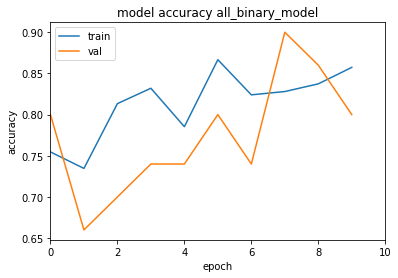

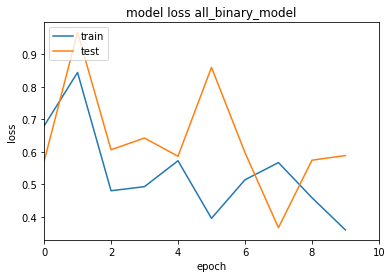

In [0]:
plot_loss_acc(train_loss, train_acc, val_loss, val_acc, path_save_fig, 'MN_binary_third_conv')

## Test:

In [0]:
# load model pretrained on Omniglot:
model = BinaryMatchingNetwork(first_binary_conv_layer, second_binary_conv_layer,
                              third_binary_conv_layer, fourth_binary_conv_layer,
                              n_train, k_train, q_train, num_input_channels)
model, use_gpu = gpu_config(model)
model.double()
model.load_state_dict(load(f'trained_models/Omniglot/matching_nets/Binary/{param_str}.pth'))

use 1 gpu who named: Tesla P100-PCIE-16GB


<All keys matched successfully>

In [0]:
# test model on evaluation dataset:
optimiser = Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.NLLLoss().cuda()

callbacks_test = [
    EvaluateFewShot(
        binary_model=binary_model,
        slope=1.0,
        use_gpu=use_gpu,
        eval_fn=matching_net_episode,
        num_tasks=evaluation_episodes,
        n_shot=n_test,
        k_way=k_test,
        q_queries=q_test,
        taskloader=evaluation_taskloader,
        prepare_batch=prepare_nshot_task(use_gpu, n_test, k_test, q_test),
        distance=distance
    ),
]

fit(
    binary_model,
    slope_annealing,
    use_gpu,
    model,
    optimiser,
    loss_fn,
    epochs=5,
    dataloader=evaluation_taskloader,
    prepare_batch=prepare_nshot_task(use_gpu, n_test, k_test, q_test),
    callbacks=callbacks_test,
    metrics=['categorical_accuracy'],
    fit_function=matching_net_episode,
    fit_function_kwargs={'n_shot': n_test, 'k_way': k_test, 'q_queries': q_test, 'distance': distance, 'train': False}
)




Epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]

Begin training...





Epoch 1:  10%|█         | 1/10 [00:03<00:32,  3.67s/it]


Epoch 1:  10%|█         | 1/10 [00:03<00:32,  3.67s/it, loss=1.6, categorical_accuracy=0.6]


Epoch 1:  20%|██        | 2/10 [00:03<00:29,  3.67s/it, loss=1.4, categorical_accuracy=0.6]


Epoch 1:  30%|███       | 3/10 [00:03<00:25,  3.67s/it, loss=1.01, categorical_accuracy=1] 


Epoch 1:  40%|████      | 4/10 [00:03<00:21,  3.67s/it, loss=1, categorical_accuracy=0.8] 


Epoch 1:  50%|█████     | 5/10 [00:07<00:14,  2.89s/it, loss=1, categorical_accuracy=0.8]


Epoch 1:  50%|█████     | 5/10 [00:07<00:14,  2.89s/it, loss=1.28, categorical_accuracy=0.8]


Epoch 1:  60%|██████    | 6/10 [00:08<00:11,  2.89s/it, loss=1.25, categorical_accuracy=0.8]


Epoch 1:  70%|███████   | 7/10 [00:08<00:08,  2.89s/it, loss=1.23, categorical_accuracy=0.8]


Epoch 1:  80%|████████  | 8/10 [00:08<00:05,  2.89s/it, loss=1.56, categorical_accuracy=0.2]


Epoch 1:  90%|█████████ | 9/10 [00:11<00:02,  2.28s/it, loss=1.56, categorical_accuracy=0.2]

Finished.


# Binary MN fourth conv layer Expes:

## Parameters:

In [0]:
##############
# Parameters #
##############
first_binary_conv_layer = False
second_binary_conv_layer = False
third_binary_conv_layer = False
fourth_binary_conv_layer = True
slope_annealing = True
binary_model = True

param_str = f'frist_conv={first_binary_conv_layer}_second_conv={second_binary_conv_layer}_'\
            f'third_conv={third_binary_conv_layer}_fourth_conv={fourth_binary_conv_layer}_'\
            f'_n={n_train}_k={k_train}_q={q_train}_' \
            f'nv={n_test}_kv={k_test}_qv={q_test}_'\
            f'dist={distance}'

## Model:

In [0]:
#########
# Model #
#########
model = BinaryMatchingNetwork(first_binary_conv_layer, second_binary_conv_layer,
                              third_binary_conv_layer, fourth_binary_conv_layer,
                              n_train, k_train, q_train, num_input_channels)
model, use_gpu = gpu_config(model)
model.double()

use 1 gpu who named: Tesla P4


BinaryMatchingNetwork(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (act_layer1): ReLU()
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (act_layer2): ReLU()
  (layer3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (act_layer3): ReLU()
  (layer4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1)

## Training:

In [0]:
optimiser = Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.NLLLoss().cuda()

callbacks = [
    EvaluateFewShot(
        binary_model=binary_model,
        slope=1.0,
        use_gpu=use_gpu,
        eval_fn=matching_net_episode,
        num_tasks=evaluation_episodes,
        n_shot=n_test,
        k_way=k_test,
        q_queries=q_test,
        taskloader=evaluation_taskloader,
        prepare_batch=prepare_nshot_task(use_gpu, n_test, k_test, q_test),
        distance=distance
    ),
    ModelCheckpoint(
        filepath=PATH + f'/trained_models/Omniglot/matching_nets/Binary/{param_str}.pth',
        monitor=f'val_{n_test}-shot_{k_test}-way_acc',
        # monitor=f'val_loss',
    ),
    ReduceLROnPlateau(patience=20, factor=0.5, monitor=f'val_{n_test}-shot_{k_test}-way_acc'),
    CSVLogger(PATH + f'/results/Omniglot_results/logs/matching_nets/Binary/{param_str}.csv'),
]

In [0]:
fit(
    binary_model,
    slope_annealing,
    use_gpu,
    model,
    optimiser,
    loss_fn,
    epochs=n_epochs,
    dataloader=background_taskloader,
    prepare_batch=prepare_nshot_task(use_gpu, n_train, k_train, q_train),
    callbacks=callbacks,
    metrics=['categorical_accuracy'],
    fit_function=matching_net_episode,
    fit_function_kwargs={'n_shot': n_train, 'k_way': k_train, 'q_queries': q_train, 'distance': distance, 'train': True}
)


Epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]

Begin training...



Epoch 1: 100%|██████████| 10/10 [00:56<00:00,  5.66s/it, loss=1.65, categorical_accuracy=0.407]

Epoch 2: 100%|██████████| 10/10 [01:00<00:00,  6.05s/it, loss=1.65, categorical_accuracy=0.419]

Epoch 3: 100%|██████████| 10/10 [01:05<00:00,  6.51s/it, loss=1.48, categorical_accuracy=0.448]

Epoch 4: 100%|██████████| 10/10 [01:01<00:00,  6.12s/it, loss=1.47, categorical_accuracy=0.475]

Epoch 5: 100%|██████████| 10/10 [01:02<00:00,  6.27s/it, loss=1.15, categorical_accuracy=0.548]

Epoch 6: 100%|██████████| 10/10 [01:03<00:00,  6.32s/it, loss=1.15, categorical_accuracy=0.551]

Epoch 7: 100%|██████████| 10/10 [01:02<00:00,  6.22s/it, loss=1.05, categorical_accuracy=0.577]

Epoch 8: 100%|██████████| 10/10 [00:50<00:00,  5.05s/it, loss=0.986, categorical_accuracy=0.613]

Epoch 9: 100%|██████████| 10/10 [00:56<00:00,  5.66s/it, loss=0.868, categorical_accuracy=0.644]

Epoch 10: 100%|██████████| 10/10 [00:46<00:00,  4.60s/it, loss=1.09, categorical_accuracy=0.607]

Finished.


## Plot acc/loss training:

In [0]:
import csv
train_acc = []
train_loss = []
val_acc = []
val_loss = []
path_save_fig = 'results/Omniglot_results/plot_acc_loss/Binary/'
with open(f'results/Omniglot_results/logs/matching_nets/Binary/{param_str}.csv', newline='') as csvfile:
     reader = csv.DictReader(csvfile)
     for row in reader:
       train_acc.append(float(row['categorical_accuracy']))
       train_loss.append(float(row['loss']))
       val_acc.append(float(row['val_1-shot_5-way_acc']))
       val_loss.append(float(row['val_loss']))

print(train_acc, train_loss, val_acc, val_loss)


[0.4066666666666666, 0.41866666666666663, 0.44800000000000006, 0.4746666666666666, 0.5479999999999998, 0.5506666666666667, 0.5773333333333334, 0.6133333333333333, 0.6439999999999999, 0.6066666666666667] [1.654174220511149, 1.6460104785587313, 1.4835960551163427, 1.4686331370065904, 1.1450904618459656, 1.151386266357157, 1.046186943050256, 0.985982530609672, 0.8678646329870865, 1.088686497559437] [0.3, 0.36, 0.44, 0.42, 0.5, 0.58, 0.54, 0.58, 0.56, 0.58] [1.678539206449245, 1.4404906109570823, 1.7343205041814715, 1.7388409849372408, 1.1717332371109273, 1.3515724486242637, 1.1462115871939298, 1.1952872976944036, 1.2874934361383483, 1.129391020889691]


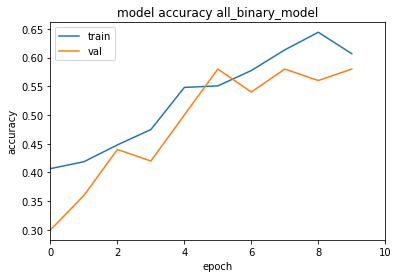

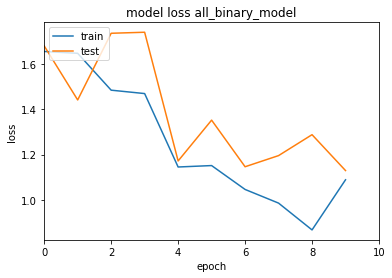

In [0]:
plot_loss_acc(train_loss, train_acc, val_loss, val_acc, path_save_fig, 'MN_binary_fourth_conv')

## Test:

In [0]:
# load model pretrained on Omniglot:
model = BinaryMatchingNetwork(first_binary_conv_layer, second_binary_conv_layer,
                              third_binary_conv_layer, fourth_binary_conv_layer,
                              n_train, k_train, q_train, num_input_channels)
model, use_gpu = gpu_config(model)
model.double()
model.load_state_dict(load(f'trained_models/Omniglot/matching_nets/Binary/{param_str}.pth'))

use 1 gpu who named: Tesla P100-PCIE-16GB


<All keys matched successfully>

In [0]:
# test model on evaluation dataset:
optimiser = Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.NLLLoss().cuda()

callbacks_test = [
    EvaluateFewShot(
        binary_model=binary_model,
        slope=1.0,
        use_gpu=use_gpu,
        eval_fn=matching_net_episode,
        num_tasks=evaluation_episodes,
        n_shot=n_test,
        k_way=k_test,
        q_queries=q_test,
        taskloader=evaluation_taskloader,
        prepare_batch=prepare_nshot_task(use_gpu, n_test, k_test, q_test),
        distance=distance
    ),
]

fit(
    binary_model,
    slope_annealing,
    use_gpu,
    model,
    optimiser,
    loss_fn,
    epochs=5,
    dataloader=evaluation_taskloader,
    prepare_batch=prepare_nshot_task(use_gpu, n_test, k_test, q_test),
    callbacks=callbacks_test,
    metrics=['categorical_accuracy'],
    fit_function=matching_net_episode,
    fit_function_kwargs={'n_shot': n_test, 'k_way': k_test, 'q_queries': q_test, 'distance': distance, 'train': False}
)




Epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]

Begin training...





Epoch 1:  10%|█         | 1/10 [00:03<00:27,  3.03s/it]


Epoch 1:  10%|█         | 1/10 [00:03<00:27,  3.03s/it, loss=1.84, categorical_accuracy=0.4]


Epoch 1:  20%|██        | 2/10 [00:03<00:18,  2.37s/it, loss=1.84, categorical_accuracy=0.4]


Epoch 1:  20%|██        | 2/10 [00:03<00:18,  2.37s/it, loss=0.511, categorical_accuracy=0.6]


Epoch 1:  30%|███       | 3/10 [00:03<00:16,  2.37s/it, loss=1.01, categorical_accuracy=0.6] 


Epoch 1:  40%|████      | 4/10 [00:06<00:12,  2.07s/it, loss=1.01, categorical_accuracy=0.6]


Epoch 1:  40%|████      | 4/10 [00:06<00:12,  2.07s/it, loss=1.17, categorical_accuracy=0.6]


Epoch 1:  50%|█████     | 5/10 [00:06<00:10,  2.07s/it, loss=2.02, categorical_accuracy=0.4]


Epoch 1:  60%|██████    | 6/10 [00:08<00:06,  1.72s/it, loss=2.02, categorical_accuracy=0.4]


Epoch 1:  60%|██████    | 6/10 [00:08<00:06,  1.72s/it, loss=0.999, categorical_accuracy=0.4]


Epoch 1:  70%|███████   | 7/10 [00:08<00:05,  1.72s/it, loss=1.23, categorical_ac

Finished.


# Vusualization:

## Modules:

In [6]:
train_data = datasets.Omniglot('./data/dataset', background=True, download=True,
                                             transform=transforms.Compose([transforms.ToTensor(),
                                                                           transforms.Normalize((0.1307,),
                                                                                                (0.3081,))]))

Files already downloaded and verified


In [0]:
def viz_filters(model):

  model.cpu()
  print("Filters conv layer 1")
  filters = model.layer1[0].weight.data.clone()
  visTensor(filters.cpu(), ch=0, allkernels=False)
  plt.ioff()
  plt.show()

  # print('color visualize')
  # plot_weights(model.cpu(), filters, single_channel = True)
  # plt.show()

  print("Filters conv layer 2")
  filters = model.layer2[0].weight.data.clone()
  visTensor(filters.cpu(), ch=0, allkernels=False)
  plt.ioff()
  plt.show()

  # print('color visualize')
  # plot_weights(model.cpu(), filters, single_channel = True)
  # plt.show()

  print("Filters conv layer 3")
  filters = model.layer3[0].weight.data.clone()
  visTensor(filters.cpu(), ch=0, allkernels=False)
  plt.ioff()
  plt.show()

  # print('color visualize')
  # plot_weights(model.cpu(), filters, single_channel = True)
  # plt.show()

  print("Filters conv layer 4")
  filters = model.layer4[0].weight.data.clone()
  visTensor(filters.cpu(), ch=0, allkernels=False)
  plt.ioff()
  plt.show()

  # print('color visualize')
  # plot_weights(model.cpu(), filters, single_channel = True)
  # plt.show()
  return

def viz_filters_no_binary_MN(model):

  model.cpu()
  print("Filters conv layer 1")
  filters = model.encoder[0][0].weight.data.clone()
  visTensor(filters.cpu(), ch=0, allkernels=False)
  plt.ioff()
  plt.show()

  # print('color visualize')
  # plot_weights(model.cpu(), filters, single_channel = True)
  # plt.show()

  print("Filters conv layer 2")
  filters = model.encoder[1][0].weight.data.clone()
  visTensor(filters.cpu(), ch=0, allkernels=False)
  plt.ioff()
  plt.show()

  # print('color visualize')
  # plot_weights(model.cpu(), filters, single_channel = True)
  # plt.show()

  print("Filters conv layer 3")
  filters = model.encoder[2][0].weight.data.clone()
  visTensor(filters.cpu(), ch=0, allkernels=False)
  plt.ioff()
  plt.show()

  # print('color visualize')
  # plot_weights(model.cpu(), filters, single_channel = True)
  # plt.show()

  print("Filters conv layer 4")
  filters = model.encoder[3][0].weight.data.clone()
  visTensor(filters.cpu(), ch=0, allkernels=False)
  plt.ioff()
  plt.show()

  # print('color visualize')
  # plot_weights(model.cpu(), filters, single_channel = True)
  # plt.show()
  return

In [0]:
def get_activations(model):

  activation = {}
  
  model.act_layer1.register_forward_hook(get_activation('conv1', activation))
  model.act_layer2.register_forward_hook(get_activation('conv2', activation))
  model.act_layer3.register_forward_hook(get_activation('conv3', activation))
  model.act_layer4.register_forward_hook(get_activation('conv4', activation))

  data = train_data[0][0].double()
  data.unsqueeze_(0)
  model.cpu()
  output = model((data, 1.0))
  # show activations conv1
  act_conv1 = activation['conv1'].squeeze()
  act_conv2 = activation['conv2'].squeeze()
  act_conv3 = activation['conv3'].squeeze()
  act_conv4 = activation['conv4'].squeeze()

  return act_conv1, act_conv2, act_conv3, act_conv4


def viz_activations(model):
  activation = {}
  
  model.act_layer1.register_forward_hook(get_activation('conv1', activation))
  model.act_layer2.register_forward_hook(get_activation('conv2', activation))
  model.act_layer3.register_forward_hook(get_activation('conv3', activation))
  model.act_layer4.register_forward_hook(get_activation('conv4', activation))

  data = train_data[0][0].double()
  data.unsqueeze_(0)
  model.cpu()
  output = model((data, 1.0))
  """
  # show activations conv1
  act_conv1 = activation['conv1'].squeeze()
  fig, axarr = plt.subplots(act_conv1.size(0), figsize=(50,50))
  print('conv1')
  for idx in range(act_conv1.size(0)):
      axarr[idx].imshow(act_conv1[idx])
  plt.show()
  """
  print('conv1')
  act_conv1 = activation['conv1'].squeeze()
  act_conv1 = act_conv1.reshape((act_conv1.shape[0],1,act_conv1.shape[1],act_conv1.shape[2]))
  visTensor(act_conv1, ch=0, allkernels=False)
  plt.ioff()
  plt.show()
  """
  # show activations conv2
  act_conv2 = activation['conv2'].squeeze()
  fig, axarr = plt.subplots(act_conv2.size(0), figsize=(50,50))
  print('conv2')
  for idx in range(act_conv2.size(0)):
      axarr[idx].imshow(act_conv2[idx])
  plt.show()
  """
  print('conv2')
  act_conv2 = activation['conv2'].squeeze()
  act_conv2 = act_conv2.reshape((act_conv2.shape[0],1,act_conv2.shape[1],act_conv2.shape[2]))
  visTensor(act_conv2, ch=0, allkernels=False)
  plt.ioff()
  plt.show()
  """
  # show activations conv3
  act_conv3 = activation['conv3'].squeeze()
  fig, axarr = plt.subplots(act_conv3.size(0), figsize=(50,50))
  print('conv3')
  for idx in range(act_conv3.size(0)):
      axarr[idx].imshow(act_conv3[idx])
  plt.show()
  """
  print('conv3')
  act_conv3 = activation['conv3'].squeeze()
  act_conv3 = act_conv3.reshape((act_conv3.shape[0],1,act_conv3.shape[1],act_conv3.shape[2]))
  visTensor(act_conv3, ch=0, allkernels=False)
  plt.ioff()
  plt.show()
  """
  # show activations conv4
  act_conv4 = activation['conv4'].squeeze()
  fig, axarr = plt.subplots(act_conv4.size(0), figsize=(50,50))
  print('conv4')
  for idx in range(act_conv4.size(0)):
      axarr[idx].imshow(act_conv4[idx])
  plt.show()
  """
  print('conv4')
  act_conv4 = activation['conv4'].squeeze()
  act_conv4 = act_conv4.reshape((act_conv4.shape[0],1,act_conv4.shape[1],act_conv4.shape[2]))
  visTensor(act_conv4, ch=0, allkernels=False)
  plt.ioff()
  plt.show()
  return


def viz_activations_no_binary(model):
  activation = {}
  
  model.encoder[0][0].register_forward_hook(get_activation('conv1', activation))
  model.encoder[1][0].register_forward_hook(get_activation('conv2', activation))
  model.encoder[2][0].register_forward_hook(get_activation('conv3', activation))
  model.encoder[3][0].register_forward_hook(get_activation('conv4', activation))

  data = train_data[0][0].double()
  data.unsqueeze_(0)
  model.cpu()
  output = model((data, 1.0))

  print('conv1')
  act_conv1 = activation['conv1'].squeeze()
  act_conv1 = act_conv1.reshape((act_conv1.shape[0],1,act_conv1.shape[1],act_conv1.shape[2]))
  visTensor(act_conv1, ch=0, allkernels=False)
  plt.ioff()
  plt.show()

  print('conv2')
  act_conv2 = activation['conv2'].squeeze()
  act_conv2 = act_conv2.reshape((act_conv2.shape[0],1,act_conv2.shape[1],act_conv2.shape[2]))
  visTensor(act_conv2, ch=0, allkernels=False)
  plt.ioff()
  plt.show()

  print('conv3')
  act_conv3 = activation['conv3'].squeeze()
  act_conv3 = act_conv3.reshape((act_conv3.shape[0],1,act_conv3.shape[1],act_conv3.shape[2]))
  visTensor(act_conv3, ch=0, allkernels=False)
  plt.ioff()
  plt.show()

  print('conv4')
  act_conv4 = activation['conv4'].squeeze()
  act_conv4 = act_conv4.reshape((act_conv4.shape[0],1,act_conv4.shape[1],act_conv4.shape[2]))
  visTensor(act_conv4, ch=0, allkernels=False)
  plt.ioff()
  plt.show()
  return

In [0]:
def heatmap(model, name_model):

    img = cv2.imread('data/dataset/omniglot-py/images_background/Alphabet_of_the_Magi/character01/0709_01.png')
    
    transparence_coef = 0.4

    print('conv1')
    activations_conv1, activations_conv2, activations_conv3, activations_conv4 = get_activations(model)
    # print(activations_conv1.shape, activations_conv1.shape)
    # average the channels of the activations
    heatmap = torch.mean(activations_conv1, dim=0).squeeze()
    # relu on top of the heatmap
    heatmap = np.maximum(heatmap, 0)
    # normalize the heatmap
    heatmap /= torch.max(heatmap)
    # draw the heatmap
    plt.matshow(heatmap.squeeze())
    plt.show()
    plt.imsave('results/Omniglot_results/heatmap/' + name_model + '_conv1.png', heatmap)
    
    # to superpose images and heatmap
    print('superposed image')
    heatmap = heatmap.numpy()
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    # superimposed_img = heatmap * transparence_coef + img
    superimposed_img = cv2.addWeighted(img,1.0,heatmap,transparence_coef,0)
    cv2.imwrite('results/Omniglot_results/heatmap/' + name_model + '_conv1_superpose.png', superimposed_img)
    plt.imshow(superimposed_img.astype('uint8'))

    print('conv2')
    heatmap = torch.mean(activations_conv2, dim=0).squeeze()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap)
    plt.matshow(heatmap.squeeze())
    plt.show()
    plt.imsave('results/Omniglot_results/heatmap/' + name_model + '_conv2.png', heatmap)
    
    # to superpose images and heatmap
    print('superposed image')
    heatmap = heatmap.numpy()
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    # superimposed_img = heatmap * transparence_coef + img
    superimposed_img = cv2.addWeighted(img,1.0,heatmap,transparence_coef,0)
    cv2.imwrite('results/Omniglot_results/heatmap/' + name_model + '_conv2_superpose.png', superimposed_img)
    plt.imshow(superimposed_img.astype('uint8'))

    print('conv3')
    heatmap = torch.mean(activations_conv3, dim=0).squeeze()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap)
    plt.matshow(heatmap.squeeze())
    plt.show()
    plt.imsave('results/Omniglot_results/heatmap/' + name_model + '_conv3.png', heatmap)
    
    # to superpose images and heatmap
    print('superposed image')
    heatmap = heatmap.numpy()
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    # superimposed_img = heatmap * transparence_coef + img
    superimposed_img = cv2.addWeighted(img,1.0,heatmap,transparence_coef,0)
    cv2.imwrite('results/Omniglot_results/heatmap/' + name_model + '_conv3_superpose.png', superimposed_img)
    plt.imshow(superimposed_img.astype('uint8'))

    print('conv4')
    heatmap = torch.mean(activations_conv4, dim=0).squeeze()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap)
    plt.matshow(heatmap.squeeze())
    plt.show()
    plt.imsave('results/Omniglot_results/heatmap/' + name_model + '_conv4.png', heatmap)
    
    # to superpose images and heatmap
    print('superposed image')
    heatmap = heatmap.numpy()
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    # superimposed_img = heatmap * transparence_coef + img
    superimposed_img = cv2.addWeighted(img,1.0,heatmap,transparence_coef,0)
    cv2.imwrite('results/Omniglot_results/heatmap/' + name_model + '_conv4_superpose.png', superimposed_img)
    plt.imshow(superimposed_img.astype('uint8'))

    return

#### Other modules:

In [0]:
def plot_weights(model, weight_tensor, single_channel = True, collated = False):
   
    if single_channel:
      if collated:
        plot_filters_single_channel_big(weight_tensor)
      else:
        plot_filters_single_channel(weight_tensor)
        
    else:
      if weight_tensor.shape[1] == 3:
        plot_filters_multi_channel(weight_tensor)
      else:
        print("Can only plot weights with three channels with single channel = False")


def plot_filters_single_channel_big(t):
    
    #setting the rows and columns
    nrows = t.shape[0]*t.shape[2]
    ncols = t.shape[1]*t.shape[3]
    
    
    npimg = np.array(t.numpy(), np.float32)
    npimg = npimg.transpose((0, 2, 1, 3))
    npimg = npimg.ravel().reshape(nrows, ncols)
    
    npimg = npimg.T
    
    fig, ax = plt.subplots(figsize=(ncols/10, nrows/200))    
    imgplot = sns.heatmap(npimg, xticklabels=False, yticklabels=False, cmap='gray', ax=ax, cbar=False)

def plot_filters_single_channel(t):
    
    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 12
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()

def plot_filters_multi_channel(t):
    
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.savefig('myimage.png', dpi=100)    
    plt.tight_layout()
    plt.show()


#custom function to fetch images from dataloader
def show_simple_image(dataloader):
  images,_ = next(iter(dataloader))
  
  #run the model on the images
  outputs = model((images, 1.0))
  
  #get the maximum class 
  _, pred = torch.max(outputs.data, 1)

  
  #call the function
  # imshow(images[0], title=[classes[x.item()] for x in pred])
  
  return images[0]


def show_batch_images(dataloader):

  images,_ = next(iter(dataloader))
  
  #run the model on the images
  outputs = model((images, 1.0))
  
  #get the maximum class 
  _, pred = torch.max(outputs.data, 1)
  
  #make grid
  img = torchvision.utils.make_grid(images)
  
  #call the function
  imshow(img, title=[classes[x.item()] for x in pred])
  
  return images, pred


def imshow(img, title):
  
  """Custom function to display the image using matplotlib"""
  
  #define std correction to be made
  std_correction = np.asarray([0.229, 0.224, 0.225]).reshape(3, 1, 1)
  
  #define mean correction to be made
  mean_correction = np.asarray([0.485, 0.456, 0.406]).reshape(3, 1, 1)
  
  #convert the tensor img to numpy img and de normalize 
  npimg = np.multiply(img, std_correction) + mean_correction
  
  #plot the numpy image
  plt.figure(figsize = (10, 10))
  plt.axis("off")
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.title(title)
  plt.show()


## No binary MN:

### Load model:

In [131]:
# Parameters 
distance = 'l2'
n_train = 1
k_train = 5
q_train = 15
n_test = 1
k_test = 5
q_test = 1

evaluation_episodes = 1000
episodes_per_epoch = 10

n_epochs = 10
dataset_class = OmniglotDataset
num_input_channels = 1

param_str = f'_n={n_train}_k={k_train}_q={q_train}_' \
            f'nv={n_test}_kv={k_test}_qv={q_test}_'\
            f'dist={distance}'

# load model pretrained on Omniglot:
model = NoBinaryMatchingNetwork(n_train, k_train, q_train, num_input_channels)
model, use_gpu = gpu_config(model)
model.double()
model.load_state_dict(load(f'trained_models/Omniglot/matching_nets/NoBinary/{param_str}.pth'))

use 1 gpu who named: Tesla P100-PCIE-16GB


<All keys matched successfully>

### Filter visualization:

Filters conv layer 1


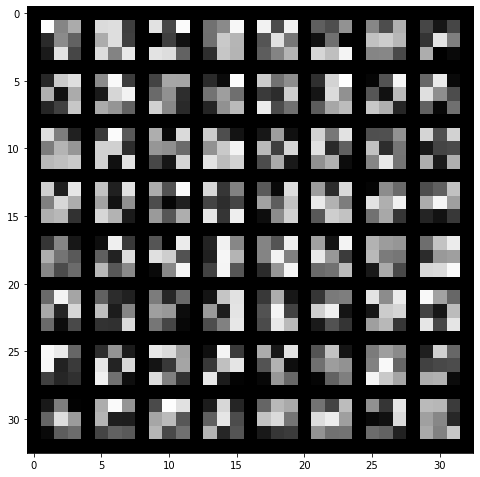

Filters conv layer 2


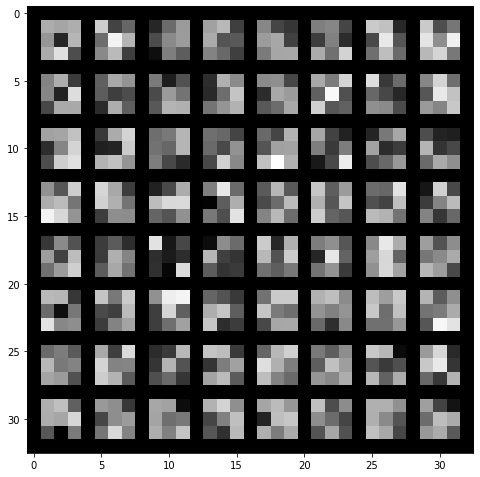

Filters conv layer 3


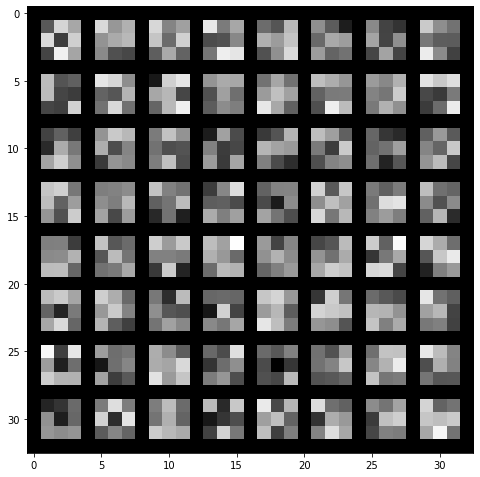

Filters conv layer 4


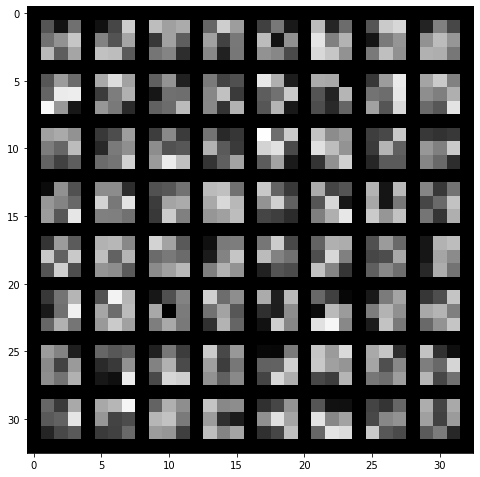

In [0]:
viz_filters_no_binary_MN(model)

### Activations visualization:

In [0]:
viz_activations_no_binary(model)

# TODO: "viz_activations_no_binary() don't work, see why"

### Heatmap visualization:

## Binary MN first conv layer:

### Load model:

In [10]:
# Parameters
first_binary_conv_layer = True
second_binary_conv_layer = False
third_binary_conv_layer = False
fourth_binary_conv_layer = False
slope_annealing = True
binary_model = True

param_str = f'frist_conv={first_binary_conv_layer}_second_conv={second_binary_conv_layer}_'\
            f'third_conv={third_binary_conv_layer}_fourth_conv={fourth_binary_conv_layer}_'\
            f'_n={n_train}_k={k_train}_q={q_train}_' \
            f'nv={n_test}_kv={k_test}_qv={q_test}_'\
            f'dist={distance}'

# model
model = BinaryMatchingNetwork(first_binary_conv_layer, second_binary_conv_layer,
                              third_binary_conv_layer, fourth_binary_conv_layer,
                              n_train, k_train, q_train, num_input_channels)
model, use_gpu = gpu_config(model)
model.double()
model.load_state_dict(load(f'trained_models/Omniglot/matching_nets/Binary/{param_str}.pth'))

use 1 gpu who named: Tesla P100-PCIE-16GB


<All keys matched successfully>

### Filter visualization:

Filters conv layer 1


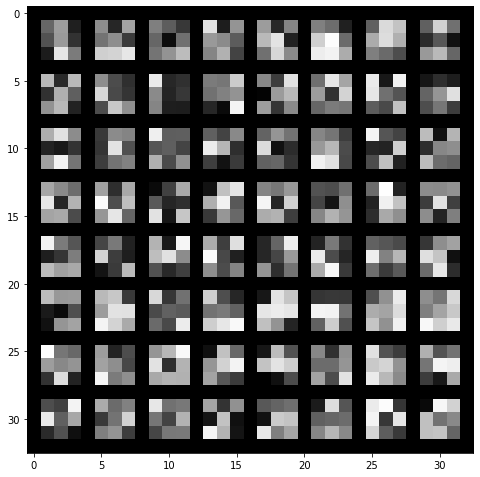

Filters conv layer 2


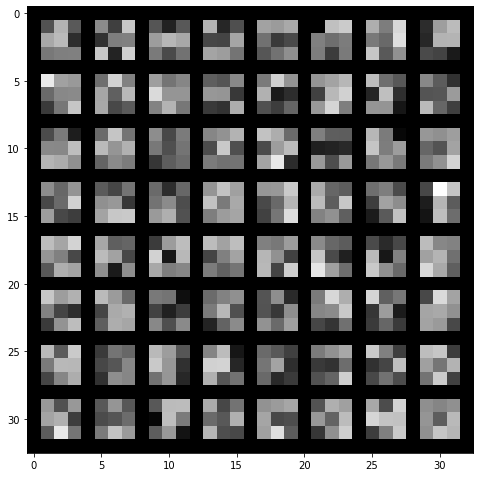

Filters conv layer 3


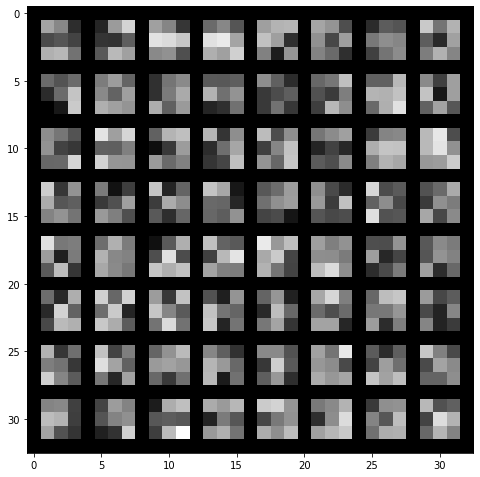

Filters conv layer 4


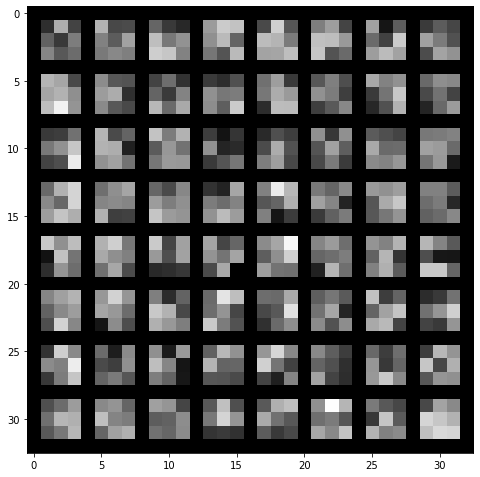

In [0]:
viz_filters(model)

### Activations visualization:

conv1


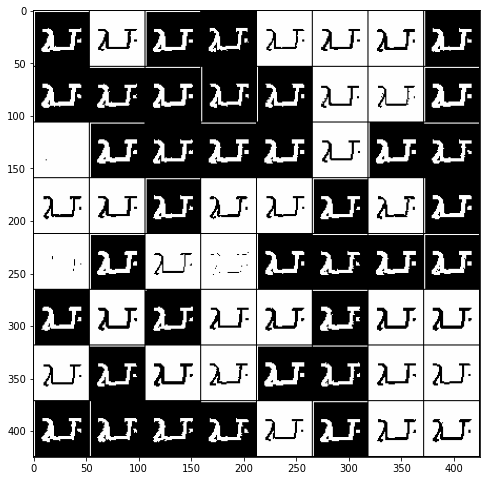

conv2


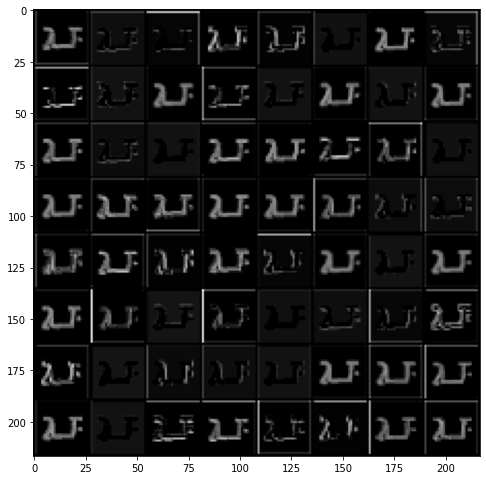

conv3


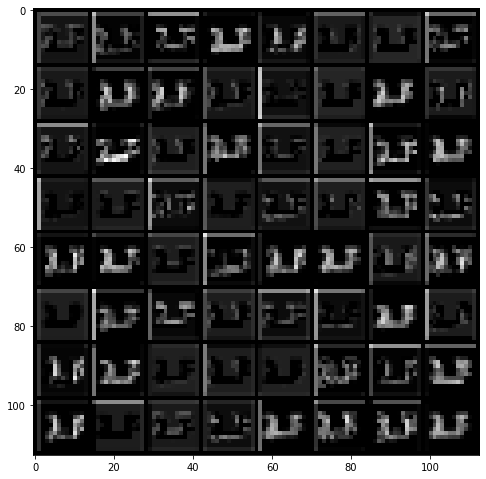

conv4


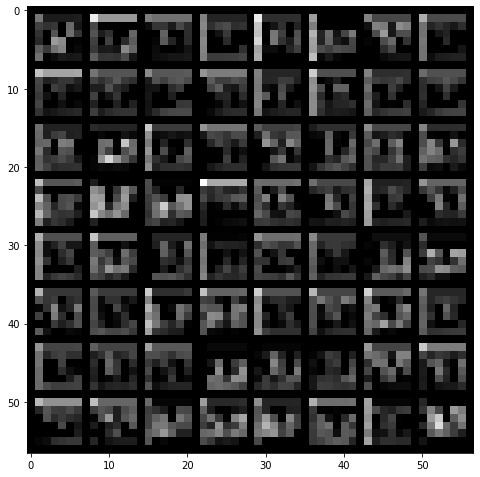

In [0]:
viz_activations(model)

### Heatmap visualization:

conv1


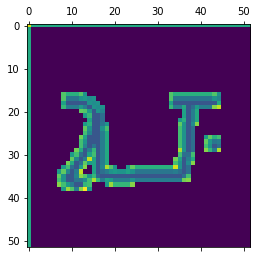

superposed image
conv2


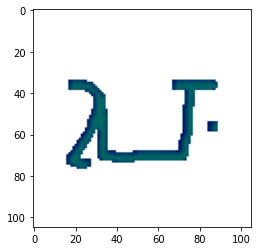

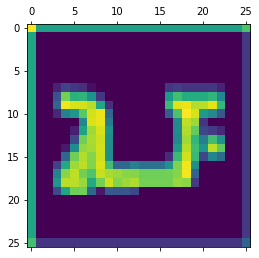

superposed image
conv3


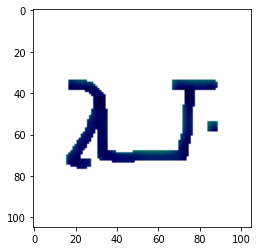

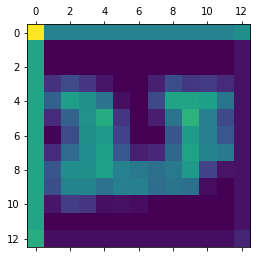

superposed image
conv4


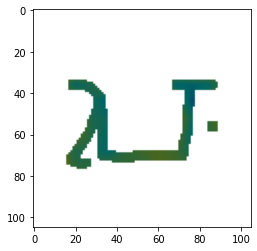

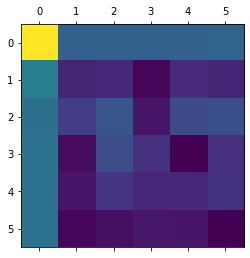

superposed image


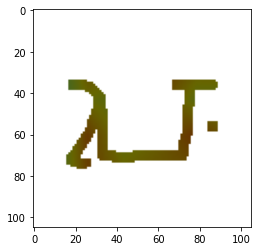

In [120]:
heatmap(model, 'binary_MN_first_conv')

## Binary MN second conv layer:

### Load model:

In [121]:
# Parameters
first_binary_conv_layer = False
second_binary_conv_layer = True
third_binary_conv_layer = False
fourth_binary_conv_layer = False
slope_annealing = True
binary_model = True

param_str = f'frist_conv={first_binary_conv_layer}_second_conv={second_binary_conv_layer}_'\
            f'third_conv={third_binary_conv_layer}_fourth_conv={fourth_binary_conv_layer}_'\
            f'_n={n_train}_k={k_train}_q={q_train}_' \
            f'nv={n_test}_kv={k_test}_qv={q_test}_'\
            f'dist={distance}'

# model
model = BinaryMatchingNetwork(first_binary_conv_layer, second_binary_conv_layer,
                              third_binary_conv_layer, fourth_binary_conv_layer,
                              n_train, k_train, q_train, num_input_channels)
model, use_gpu = gpu_config(model)
model.double()
model.load_state_dict(load(f'trained_models/Omniglot/matching_nets/Binary/{param_str}.pth'))

use 1 gpu who named: Tesla P100-PCIE-16GB


<All keys matched successfully>

### Filter visualization:

Filters conv layer 1


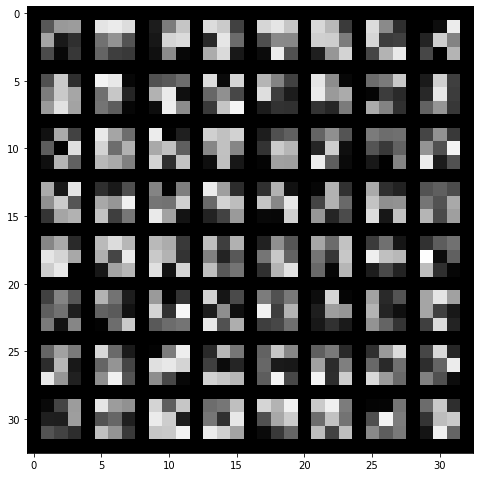

Filters conv layer 2


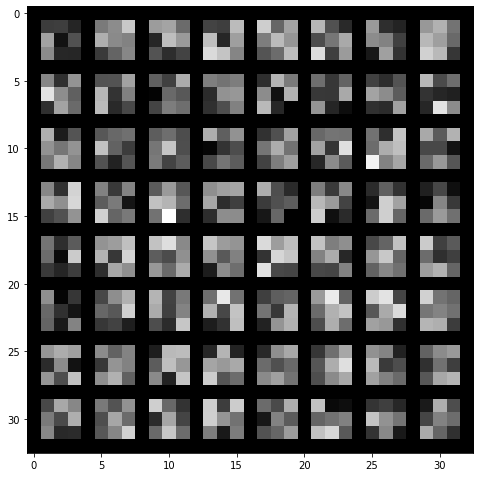

Filters conv layer 3


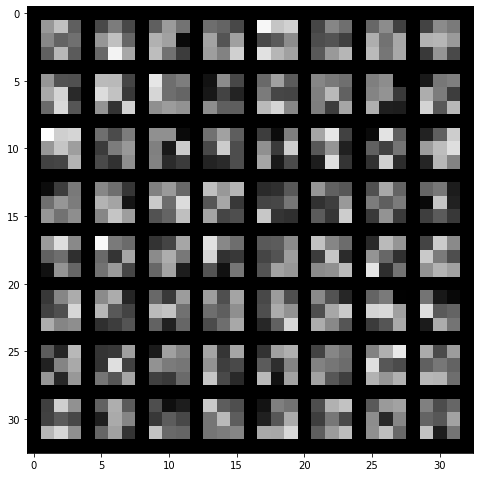

Filters conv layer 4


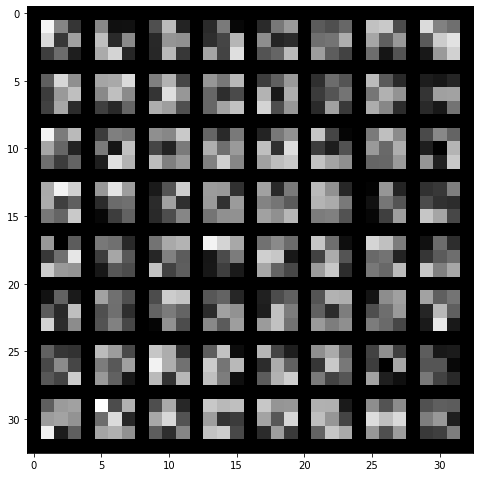

In [0]:
viz_filters(model)

### Activations visualization:

conv1


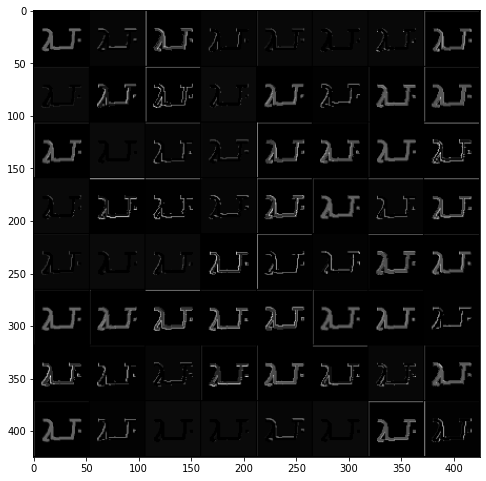

conv2


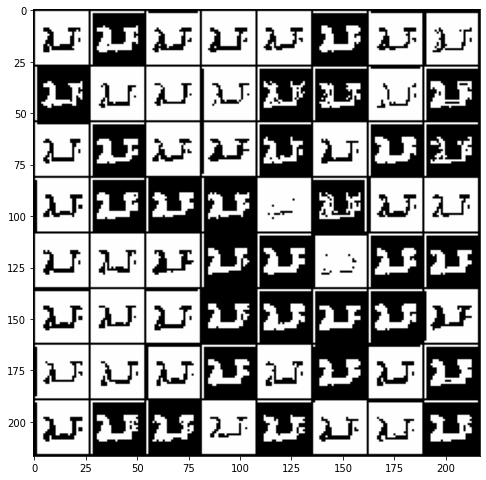

conv3


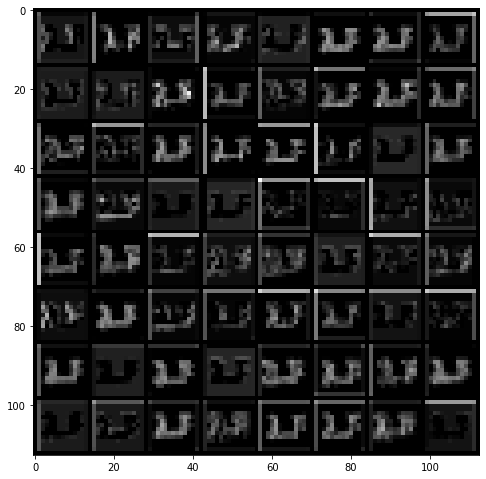

conv4


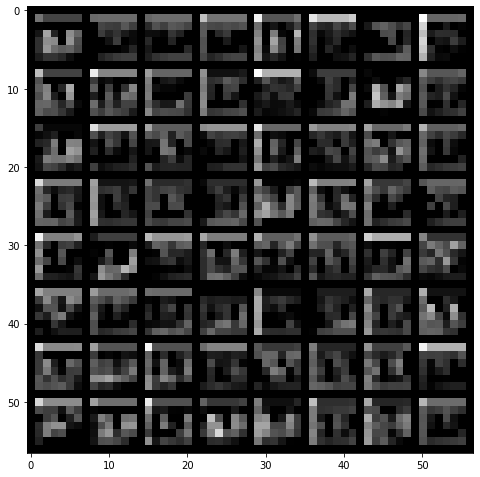

In [0]:
viz_activations(model)

### Heatmap visualization:

conv1


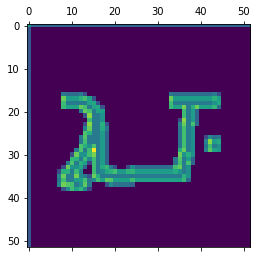

superposed image
conv2


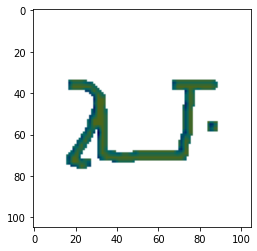

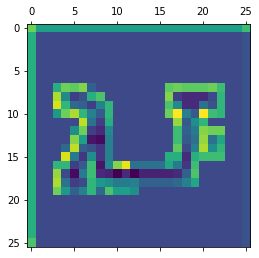

superposed image
conv3


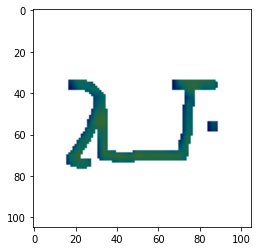

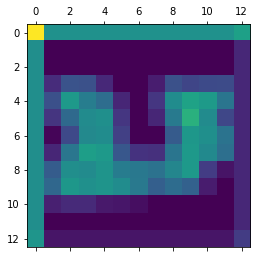

superposed image
conv4


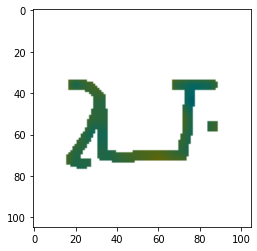

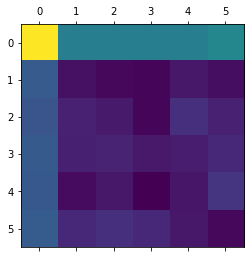

superposed image


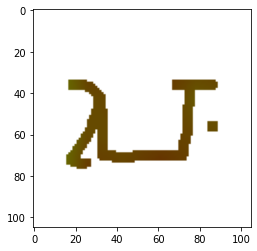

In [122]:
heatmap(model, 'binary_MN_second_conv')

## Binary MN third conv layer:

### Load model:

In [123]:
# Parameters
first_binary_conv_layer = False
second_binary_conv_layer = False
third_binary_conv_layer = True
fourth_binary_conv_layer = False
slope_annealing = True
binary_model = True

param_str = f'frist_conv={first_binary_conv_layer}_second_conv={second_binary_conv_layer}_'\
            f'third_conv={third_binary_conv_layer}_fourth_conv={fourth_binary_conv_layer}_'\
            f'_n={n_train}_k={k_train}_q={q_train}_' \
            f'nv={n_test}_kv={k_test}_qv={q_test}_'\
            f'dist={distance}'

# model
model = BinaryMatchingNetwork(first_binary_conv_layer, second_binary_conv_layer,
                              third_binary_conv_layer, fourth_binary_conv_layer,
                              n_train, k_train, q_train, num_input_channels)
model, use_gpu = gpu_config(model)
model.double()
model.load_state_dict(load(f'trained_models/Omniglot/matching_nets/Binary/{param_str}.pth'))

use 1 gpu who named: Tesla P100-PCIE-16GB


<All keys matched successfully>

### Filter visualization:

Filters conv layer 1


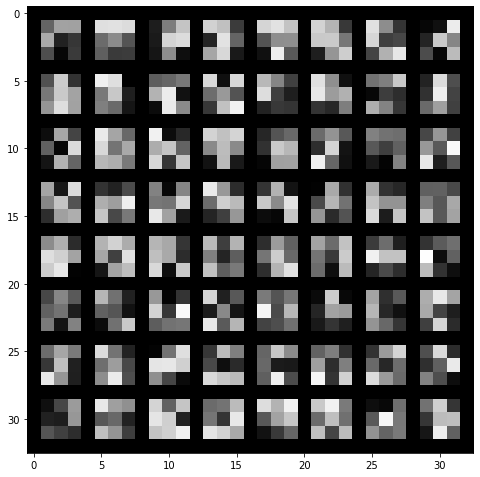

Filters conv layer 2


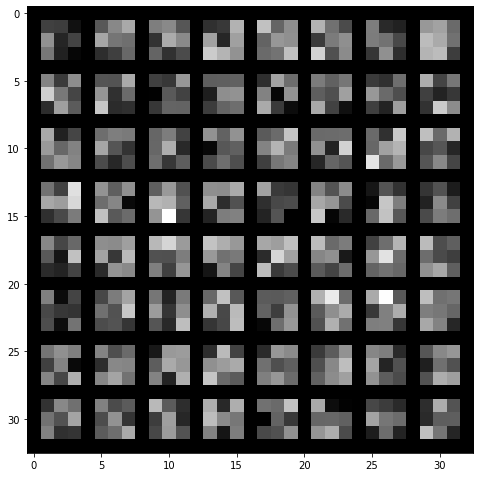

Filters conv layer 3


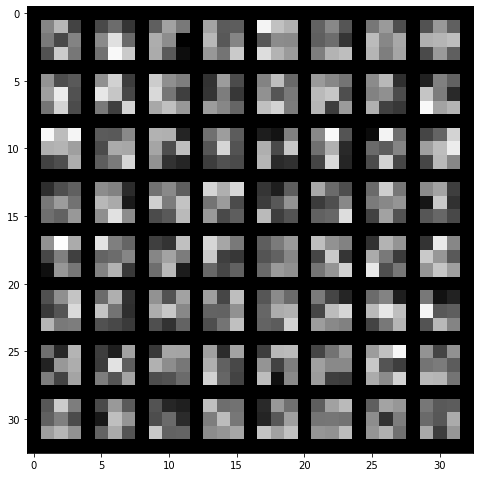

Filters conv layer 4


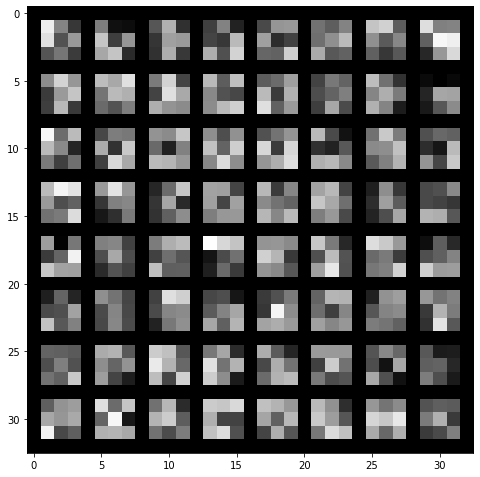

In [0]:
viz_filters(model)

### Activations visualization:

conv1


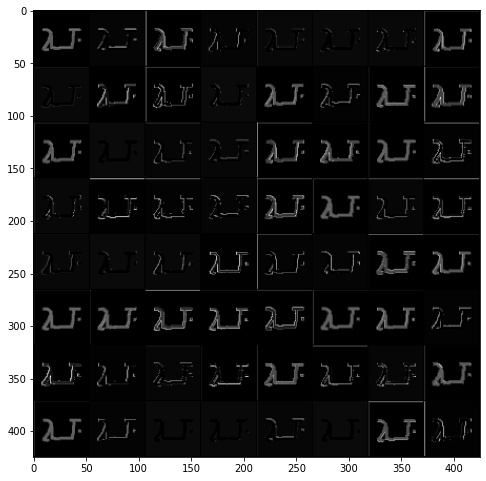

conv2


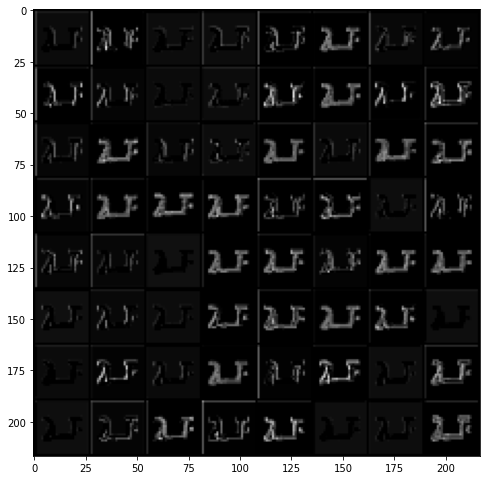

conv3


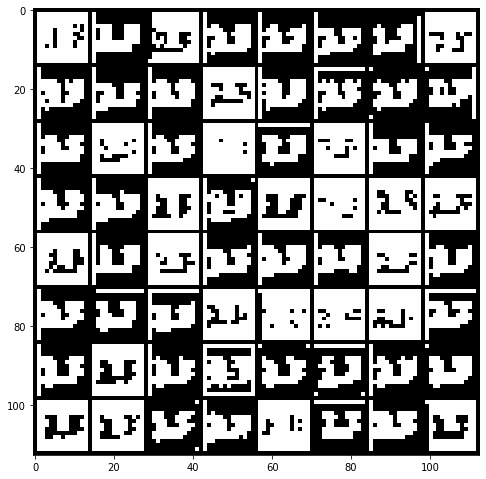

conv4


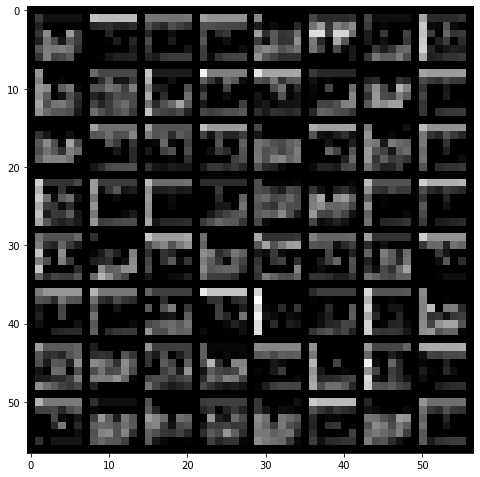

In [0]:
viz_activations(model)

### Heatmap visualization:

conv1


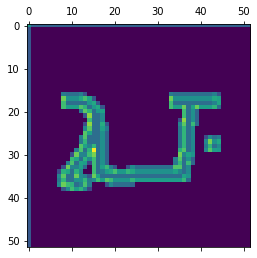

superposed image
conv2


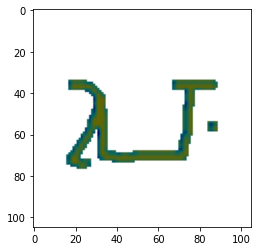

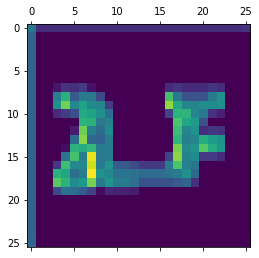

superposed image
conv3


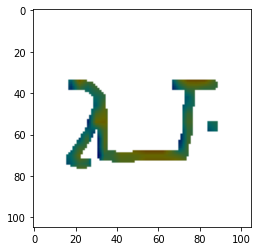

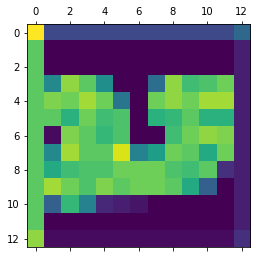

superposed image
conv4


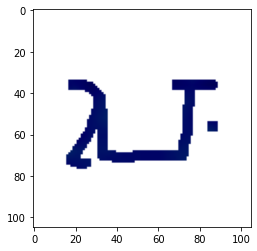

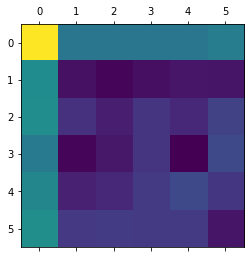

superposed image


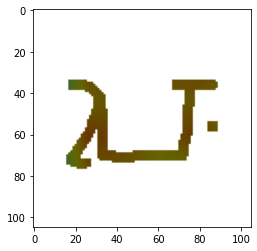

In [124]:
heatmap(model, 'binary_MN_third_conv')

## Binary MN fourth conv layer:

### Load model:

In [125]:
# Parameters
first_binary_conv_layer = False
second_binary_conv_layer = False
third_binary_conv_layer = False
fourth_binary_conv_layer = True
slope_annealing = True
binary_model = True

param_str = f'frist_conv={first_binary_conv_layer}_second_conv={second_binary_conv_layer}_'\
            f'third_conv={third_binary_conv_layer}_fourth_conv={fourth_binary_conv_layer}_'\
            f'_n={n_train}_k={k_train}_q={q_train}_' \
            f'nv={n_test}_kv={k_test}_qv={q_test}_'\
            f'dist={distance}'

# model
model = BinaryMatchingNetwork(first_binary_conv_layer, second_binary_conv_layer,
                              third_binary_conv_layer, fourth_binary_conv_layer,
                              n_train, k_train, q_train, num_input_channels)
model, use_gpu = gpu_config(model)
model.double()
model.load_state_dict(load(f'trained_models/Omniglot/matching_nets/Binary/{param_str}.pth'))

use 1 gpu who named: Tesla P100-PCIE-16GB


<All keys matched successfully>

### Filter visualization:

Filters conv layer 1


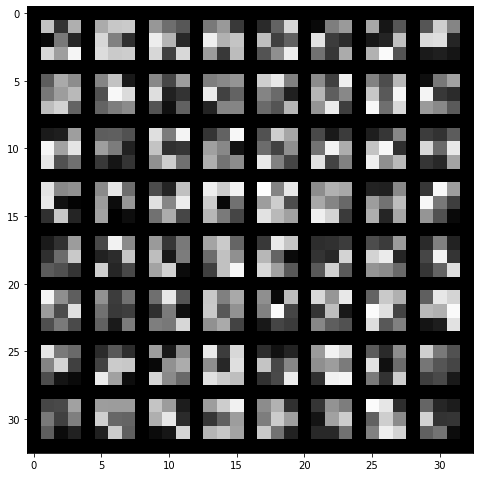

Filters conv layer 2


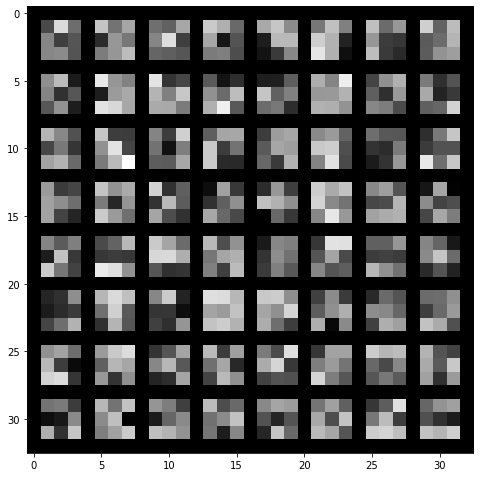

Filters conv layer 3


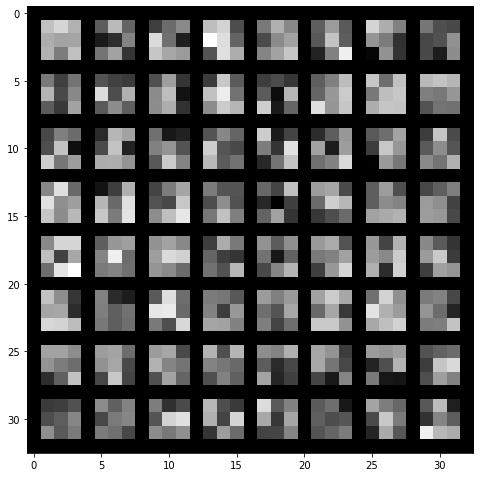

Filters conv layer 4


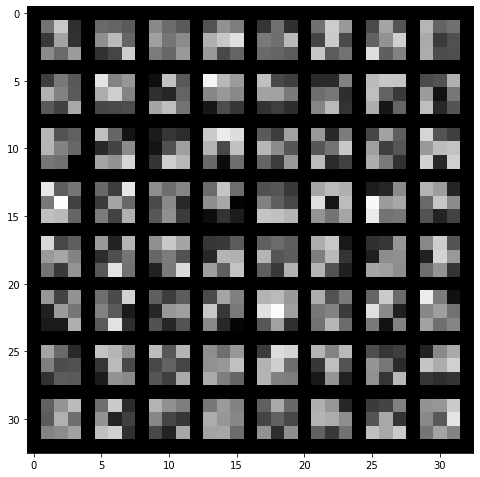

In [0]:
viz_filters(model)

### Activations visualization:

conv1


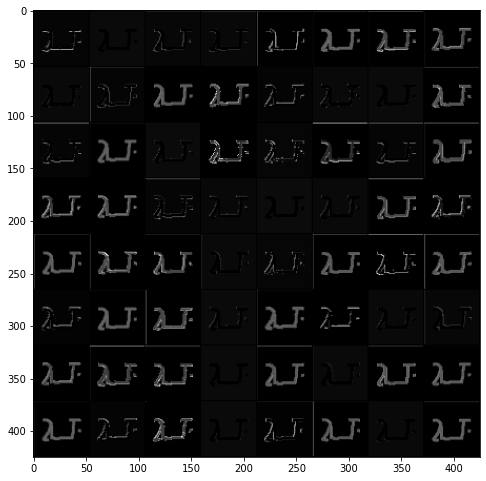

conv2


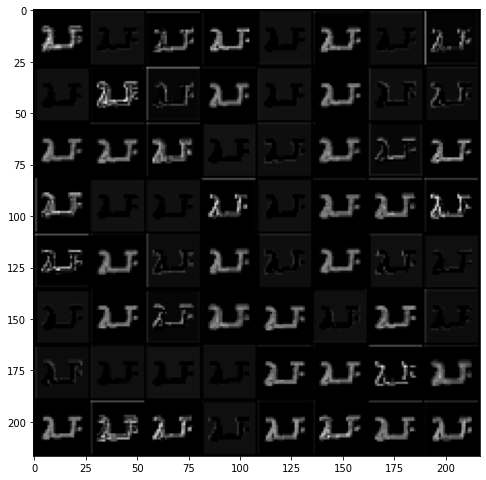

conv3


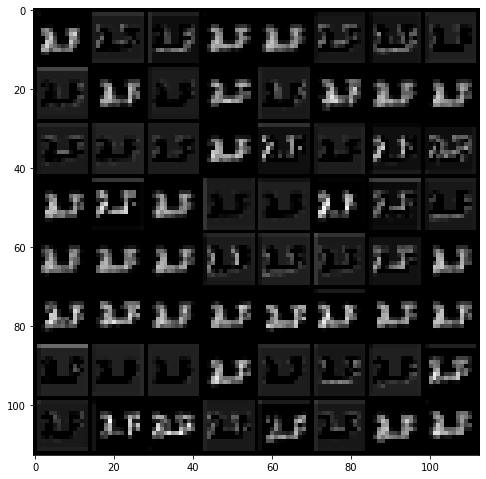

conv4


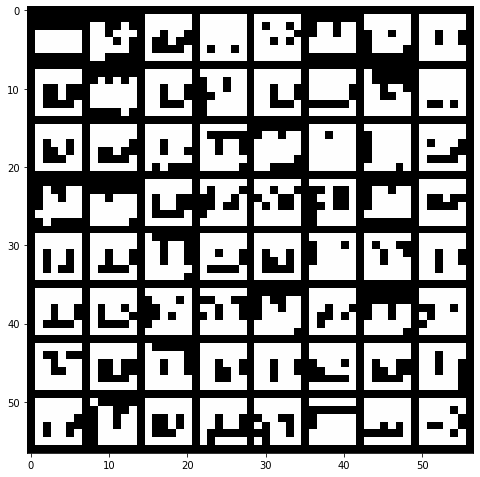

In [0]:
viz_activations(model)

### Heatmap visualization:

conv1


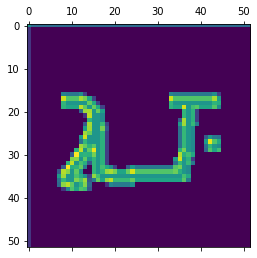

superposed image
conv2


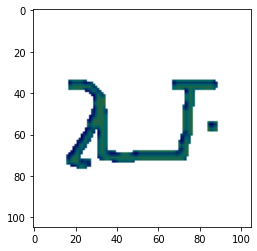

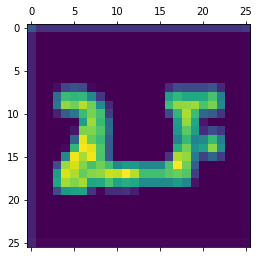

superposed image
conv3


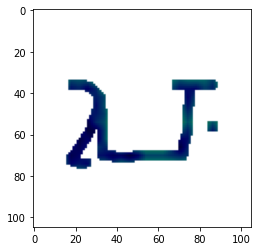

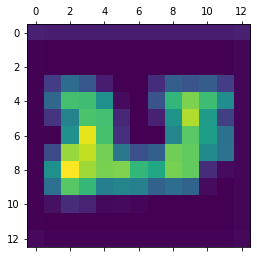

superposed image
conv4


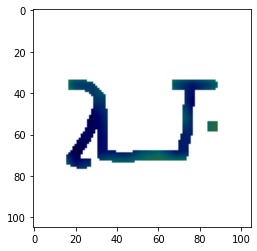

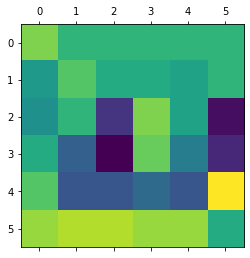

superposed image


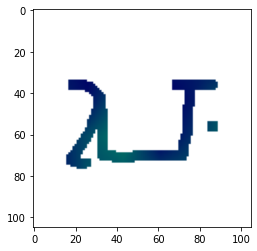

In [126]:
heatmap(model, 'binary_MN_fourth_conv')